In [2]:
excludes = ['power.Core']

def parse_data(data_folder, workloads):
    data = {}

    for wl in workloads:
        baseline_res = get_results_map(data_folder, wl)
        data[wl] = baseline_res

    return data


def get_results_map(fodler_path, workload):
    filename = fodler_path + "/" + workload + ".txt" 
    d = {}
    with open(filename, "r") as file:
        lines = file.readlines()

        for line in lines:
            line = line.strip()
            splits = line.split(" ")

            if (not splits[0].startswith("power.")):    
                d[splits[0]] = float(splits[2])


    return d


import os


# remove the csv files in the res folder
def remove_csv_files_in_res():
    res_path = 'res'
    for folder_name in os.listdir(res_path):
        folder_path = os.path.join(res_path, folder_name)
        if not os.path.isdir(folder_path):
            continue
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                os.remove(os.path.join(folder_path, file_name))

# Call the function to remove CSV files
remove_csv_files_in_res()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt



workloads = [
    "bc",
    "bfs",
    "cc",
    "dlrm",
    "gc",
    "gen",
    "pr",
    "rnd",
    "sssp",
    "tc",
    "xs"
]





# Configs
config = 7

paths = [
    f'./configurations/config{config}/radix', 
    f'./configurations/config{config}/victima', 
    # f'./configurations/config{config}/complete_bypass_l2', 
    f'./configurations/config{config}/complete_bypass_l2_leaf_pte',
    f'./configurations/config9/complete_bypass_l2_leaf_pte_dtlb_pred',
    f'./configurations/config10/complete_bypass_l2_leaf_pte_dtlb_pred',
    # f'./configurations/config{config}/perfect_l2_pte',
    # f'./configurations/config{config}/perfect_l2_tlb',
    # f'./configurations/config{config}/perfect_l1_tlb',
]
headings = [
    'Radix', 
    'Victima', 
    # 'Complete bypass l2', 
    'Complete bypass l2 leaf pte',
    'Dead TLB Blocks not bypassed',
    'Dead TLB Blocks bypassed',
    # 'Perfect L2 for PTE',
    # 'Perfect STLB',
    # 'Perfect DTLB 1.5K entries',
]




data_dfs = []


for path in paths:
    res = parse_data(path, workloads)
    data_df = pd.DataFrame(res)
    data_dfs.append(data_df)



## The plot configurations

In [4]:
# Define a configuration dictionary including legend font size
plot_config = {
    "font.size": 20,               # Base font size
    "axes.titlesize": 18,          # Title font size
    "axes.labelsize": 16,          # X and Y label font size
    "xtick.labelsize": 16,         # X-axis tick label font size
    "ytick.labelsize": 16,         # Y-axis tick label font size
    "legend.fontsize": 16,         # Legend font size
    "figure.titlesize": 16         # Figure title font size
}

# Apply the configuration globally
plt.rcParams.update(plot_config)
# make the plot wider
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [5]:
def convert_to_cycles(femtosecs):
    return femtosecs / 384615

In [6]:
def compare(dfs, labels, mean_type = 'mean', plot = False):
    merged_df = pd.concat(dfs, axis=1)
    merged_df.columns = labels


    if (mean_type == 'geomean'):
        merged_df.loc['GEOMEAN'] = merged_df.apply(lambda x: x.prod()**(1/len(x)), axis=0)
    elif (mean_type == 'mean'):
        merged_df.loc['MEAN'] = merged_df.mean()
    else:
        pass

    # if (plot):
    #     merged_df.T.plot(kind='bar')
    #     plt.show()

    
    return merged_df


In [7]:
# generic get attribute function
def get_attr(df, attr, label):
    dt = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dt.at[label, wl] = df[wl][attr]

    return dt.T


def compare_attr(dfs, labels, attr):
    mer = [get_attr(df, attr, label) for df, label in zip(dfs, labels)]
    return compare(mer, labels)


## DTLB & STLB MPKI

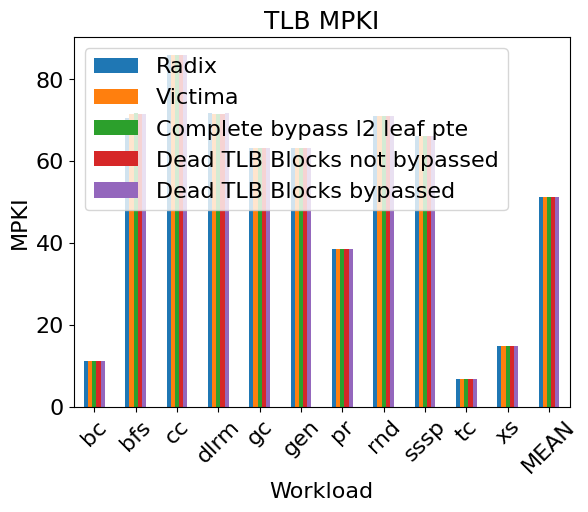

In [8]:
def get_tlb_mpki(df, tlb_name):
    label = 'MPKI'

    mpki = pd.DataFrame(index=[label], columns=workloads)
    attr = tlb_name + '.' + 'miss'

    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][attr] / df[wl]['core.instructions'] * 1000, 2)

    return mpki.T


compa = []

for df, label in zip(data_dfs, headings):
    compa.append(get_tlb_mpki(df, 'stlb'))
    


cmp = compare(compa, headings, mean_type='mean')


cmp.to_csv('tlb_mpki.csv')

cmp.to_csv('res/MPKI/TLB MPKI.csv')


# plot cmp
cmp.plot(kind='bar')
plt.title('TLB MPKI')
plt.xlabel('Workload')
plt.ylabel('MPKI')
plt.xticks(rotation=45)
plt.legend(loc='best')
# plt.tight_layout()
plt.show()

## Get STLB Miss Penalties

In [9]:
def get_stlb_miss_penalties_df(df):
    label = 'STLB Miss Penalty'
    # Initialize an empty DataFrame with 'STLB Miss Penalty' as the index
    stlb_miss_penalty = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # Compute the STLB miss penalty

        if df[wl]['stlb.miss'] == 0:
            penalty = 0
        else:
            # penalty = convert_to_cycles(df[wl]['mmu.total_ptw_latency'] / df[wl]['stlb.miss'])
        
            penalty = convert_to_cycles((df[wl]['ptw_radix_0.page_level_latency_0'] + df[wl]['ptw_radix_0.page_level_latency_1'] 
                                     + df[wl]['ptw_radix_0.page_level_latency_2'] + df[wl]['ptw_radix_0.page_level_latency_3'] 
                                     + df[wl]['ptw_radix_0.page_level_latency_4']) / df[wl]['stlb.miss'])
        

        stlb_miss_penalty.at[label, wl] = round(penalty, 2)

    return stlb_miss_penalty.T


def get_fraction_mmu_time(df):
    label = 'Fraction MMU Time'
    # Initialize an empty DataFrame with 'STLB Miss Penalty' as the index
    fraction_mmu_time = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # Compute the STLB miss penalty

    
        fraction_mmu_time.at[label, wl] = round(df[wl]['mmu.total_latency']/df[wl]['global.time'], 2)

    return fraction_mmu_time.T





         Radix   Victima Complete bypass l2 leaf pte  \
bc        0.75      0.71                        0.66   
bfs       0.62      0.52                        0.49   
cc        0.81      0.68                        0.63   
dlrm      0.62      0.52                        0.48   
gc        0.71      0.65                        0.56   
gen       0.71      0.65                        0.56   
pr        0.44      0.36                        0.34   
rnd       5.06      3.34                        1.12   
sssp      1.06      1.02                        0.94   
tc         0.4      0.36                        0.32   
xs        0.98      0.69                        0.43   
MEAN  1.105455  0.863636                    0.593636   

     Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
bc                           0.69                     0.72  
bfs                           0.5                     0.51  
cc                           0.65                     0.67  
dlrm                       

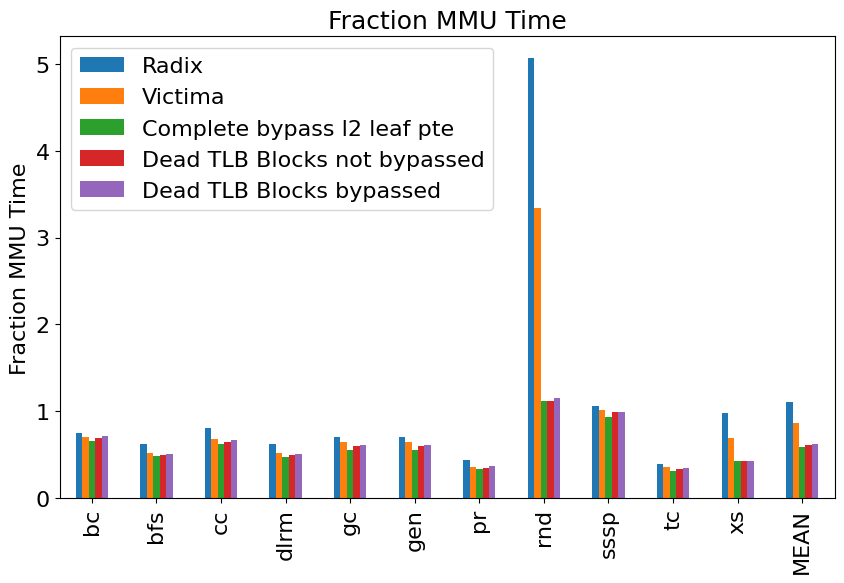

In [10]:
frac = []
for df in data_dfs:
    frac.append(get_fraction_mmu_time(df))

# print(ptw_lats[0])

cmp = compare(frac, headings)

print(cmp)

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Fraction MMU Time')
plt.title('Fraction MMU Time')
plt.show()

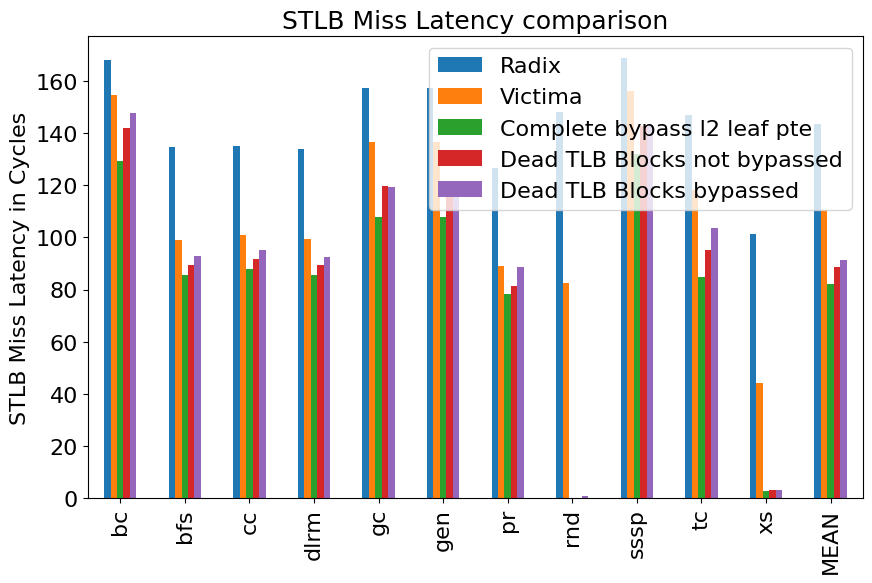

In [11]:


ptw_lats = []
for df in data_dfs:
    ptw_lats.append(get_stlb_miss_penalties_df(df))

# print(ptw_lats[0])

cmp = compare(ptw_lats, headings)

# print(cmp)

cmp.to_csv('res/Latencies/STLB Miss Penalty.csv')

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('STLB Miss Latency in Cycles')
plt.title('STLB Miss Latency comparison')
plt.show()


## Reduction in PTWs

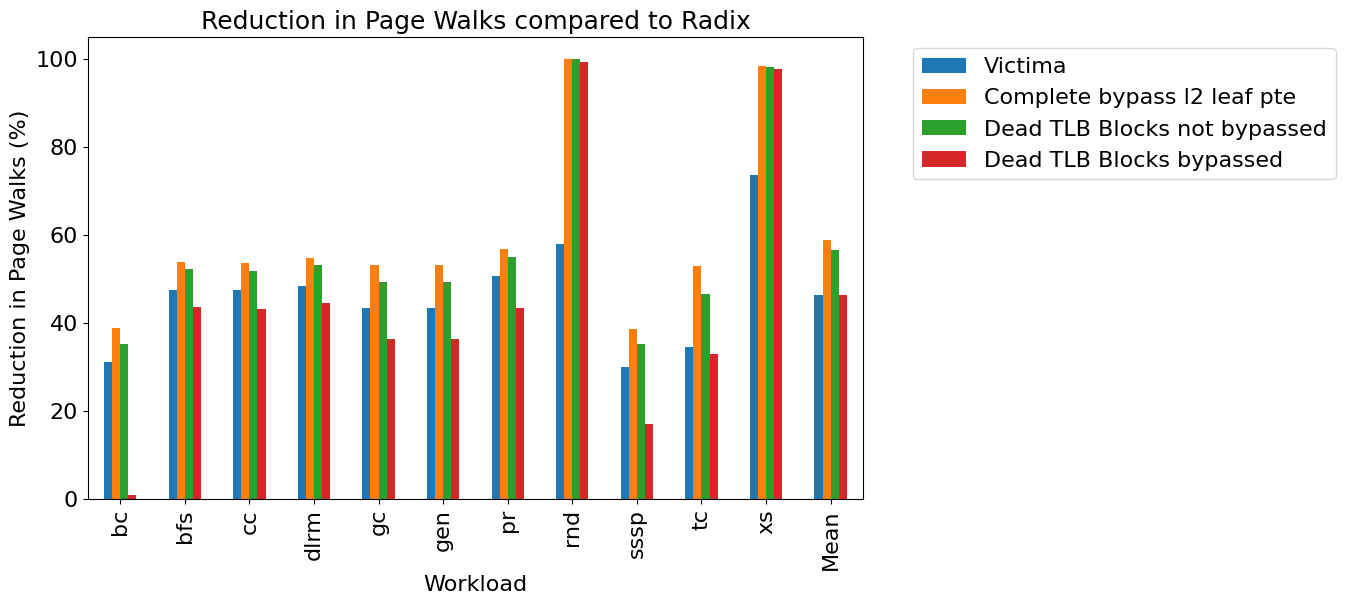

            Victima Complete bypass l2 leaf pte Dead TLB Blocks not bypassed  \
Workload                                                                       
bc        31.094679                     38.9546                    35.342235   
bfs       47.498186                   53.963611                     52.25087   
cc        47.515044                   53.720152                    51.891058   
dlrm      48.416358                   54.874511                    53.161209   
gc        43.480572                   53.286922                    49.258336   
gen       43.488765                   53.291998                    49.310232   
pr        50.602406                   56.853098                    54.928578   
rnd       57.891936                   99.952167                    99.925369   
sssp      30.100244                    38.77582                    35.195277   
tc        34.466989                   52.962197                    46.646586   
xs        73.740315                   98

In [12]:
def compute_reduction(df):
    """
    Takes a DataFrame with 'Radix' as the first column and returns a new DataFrame
    with percentage reduction in page table walks compared to 'Radix'.
    """
    # Extract the Radix column
    radix_col = df['Radix']

    # Compute the reduction for other columns
    reduction_df = df.drop(columns=['Radix']).apply(lambda col: ((radix_col - col) / radix_col) * 100)

    # Optionally, rename the columns to indicate percentage
    reduction_df = reduction_df.rename(columns=lambda x: f"{x}")

    return reduction_df



cmp = compare_attr(data_dfs, headings, 'PTW_0.page_walks')

cmp = compute_reduction(cmp)

cmp.index = workloads + ['Mean']
cmp.index.name = 'Workload'


cmp.plot(kind='bar', figsize=(10, 6))


plt.ylabel('Reduction in Page Walks (%)')
plt.title('Reduction in Page Walks compared to Radix')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

print(cmp)

cmp.to_csv('res/PTW/Reduction in Page Walks.csv')


## Average PTW latency

In [13]:
def get_avg_ptw_latency(df):
    label = 'Average PTW Latency'
    # Initialize an empty DataFrame with 'STLB Miss Penalty' as the index
    avg_ptw_lat = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # Compute the STLB miss penalty
        if df[wl]['PTW_0.page_walks'] == 0:
            penalty = 0
        else:
            penalty = convert_to_cycles((df[wl]['ptw_radix_0.page_level_latency_0'] + df[wl]['ptw_radix_0.page_level_latency_1'] 
                                        + df[wl]['ptw_radix_0.page_level_latency_2'] + df[wl]['ptw_radix_0.page_level_latency_3'] 
                                        + df[wl]['ptw_radix_0.page_level_latency_4']) / df[wl]['PTW_0.page_walks'])
            avg_ptw_lat.at[label, wl] = round(penalty, 2)

    return avg_ptw_lat.T


In [14]:
compare_attr(data_dfs, headings, 'PTW_0.page_walks')

,Radix,Victima,Complete bypass l2 leaf pte,Dead TLB Blocks not bypassed,Dead TLB Blocks bypassed
bc,5602563.0,3860464.0,3420107.0,3622492.0,5550093.0
bfs,35295190.0,18530615.0,16248631.0,16853146.0,19869400.0
cc,42995271.0,22566049.0,19898146.0,20684570.0,24380179.0
dlrm,35946361.0,18542442.0,16220971.0,16836841.0,19955064.0
gc,31622408.0,17872804.0,14771800.0,16045736.0,20093864.0
gen,31621652.0,17869786.0,14769842.0,16028942.0,20084274.0
pr,19296551.0,9532032.0,8325864.0,8697230.0,10935126.0
rnd,35551041.0,14969855.0,17005.0,26532.0,250305.0
sssp,33077609.0,23121168.0,20251495.0,21435853.0,27458017.0
tc,3391976.0,2222864.0,1595511.0,1809735.0,2272997.0


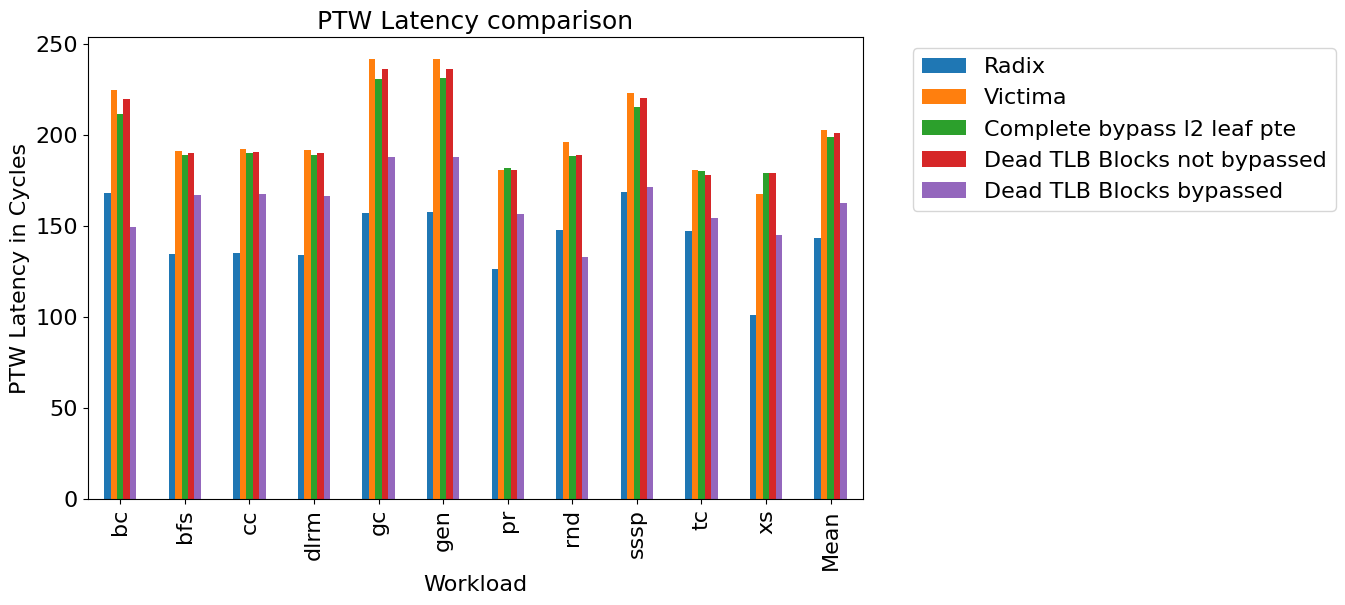

In [15]:


ptw_lats = []
for df in data_dfs:
    ptw_lats.append(get_avg_ptw_latency(df))

cmp = compare(ptw_lats, headings)

cmp.index = workloads + ['Mean']
cmp.index.name = 'Workload'

cmp.to_csv('ptw_lats.csv')
cmp.to_csv('res/Latencies/Average PTW Latencies.csv')

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('PTW Latency in Cycles')
plt.title('PTW Latency comparison')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()


## Get Cache MPKI

In [16]:
MISSES_TLB_BLOCKS = 'load-misses-tlb_entry'
MISSES_DATA_BLOCKS = 'load-misses-non_page_table'
MISSES_PTE_BLOCKS = 'load-misses-page_table'

DATA_BLOCK = 'Data'
PTE_BLOCK = 'PTE'
TLB_BLOCK = 'TLB'


block_type = {
    MISSES_TLB_BLOCKS: TLB_BLOCK,
    MISSES_DATA_BLOCKS: DATA_BLOCK,
    MISSES_PTE_BLOCKS: PTE_BLOCK,
}



# Now return a df as done in the previous function
def get_cache_mpki(df, cache_name, misses_name):
    # label = f'{cache_name} {block_type[misses_name]} MPKI'
    label = 'MPKI'

    mpki = pd.DataFrame(index=[label], columns=workloads)
    attr = cache_name + '.' + misses_name

    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][attr] / df[wl]['core.instructions'] * 1000, 2)

    return mpki.T



### Writebacks Per Kilo Instructions

In [17]:
# compare([get_cache_mpki(data_dfs[i], 'L2', MISSES_TLB_BLOCKS) for i in range(len(data_dfs))], headings)
# compare([get_cache_mpki(data_dfs[i], 'L2', 'evict-M') for i in range(len(data_dfs))], headings)


def get_all_cache_writebacks(df, heading):
    mpk1 = get_cache_mpki(df, 'L1-D', 'evict-M')
    mpk2 = get_cache_mpki(df, 'L2', 'evict-M')
    mpk3 = get_cache_mpki(df, 'nuca-cache', 'writebacks')

    cmp = compare([mpk1, mpk2, mpk3], ['L1-D', 'L2', 'LLC'])

    cmp.index = workloads + ['Mean']
    cmp.index.name = 'Workload'

    print(cmp)


    cmp.to_csv(f'all_cache_writebacks-{heading}.csv')
    cmp.to_csv(f'res/Writebacks/{heading}.csv')


    cmp.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Writebacks per kilo instructions')
    plt.xlabel('Workloads')

    plt.title(heading)
    plt.xticks(rotation=45)
    plt.show()

# for df, heading in zip(data_dfs, headings):
#     get_all_cache_writebacks(df, heading)



               Radix     Victima Complete bypass l2 leaf pte  \
Workload                                                       
bc             22.55       22.62                         0.0   
bfs            143.4       143.7                         0.0   
cc            173.89      174.09                         0.0   
dlrm          143.49       143.7                         0.0   
gc            121.85      122.73                         0.0   
gen           121.84      122.73                         0.0   
pr            130.31      130.34                         0.0   
rnd            76.18       76.22                         0.0   
sssp          150.68      150.97                         0.0   
tc              20.1        20.1                         0.0   
xs             34.09       34.17                         0.0   
Mean      103.489091  103.760909                         0.0   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                              

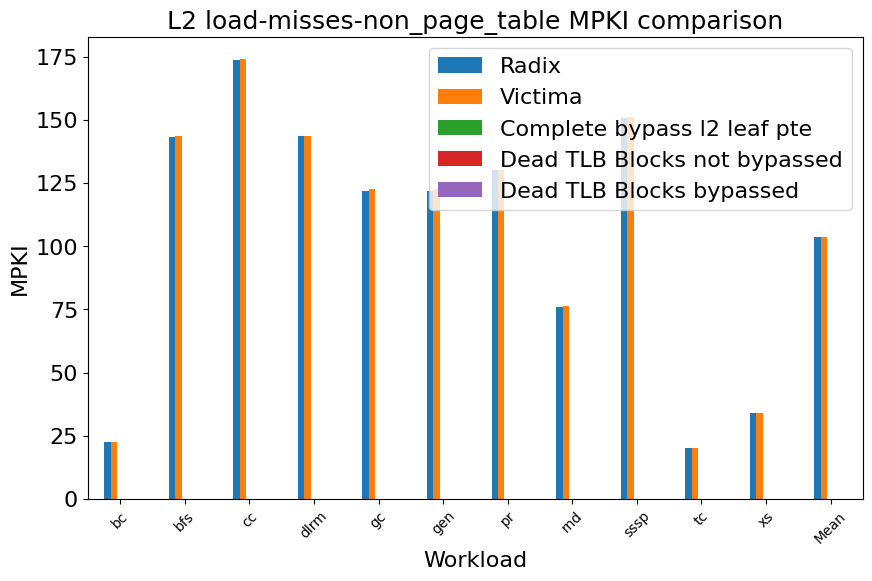

         Radix    Victima Complete bypass l2 leaf pte  \
Workload                                                
bc         0.0       7.93                        6.86   
bfs        0.0      38.94                       32.55   
cc         0.0      47.26                       39.87   
dlrm       0.0      38.97                        32.5   
gc         0.0      38.87                       29.73   
gen        0.0      38.86                       29.73   
pr         0.0      19.74                       16.67   
rnd        0.0      37.64                        0.03   
sssp       0.0      47.81                       40.59   
tc         0.0       4.81                         3.2   
xs         0.0       5.85                        0.25   
Mean       0.0  29.698182                   21.089091   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
bc                               7.28                     0.05  
bfs   

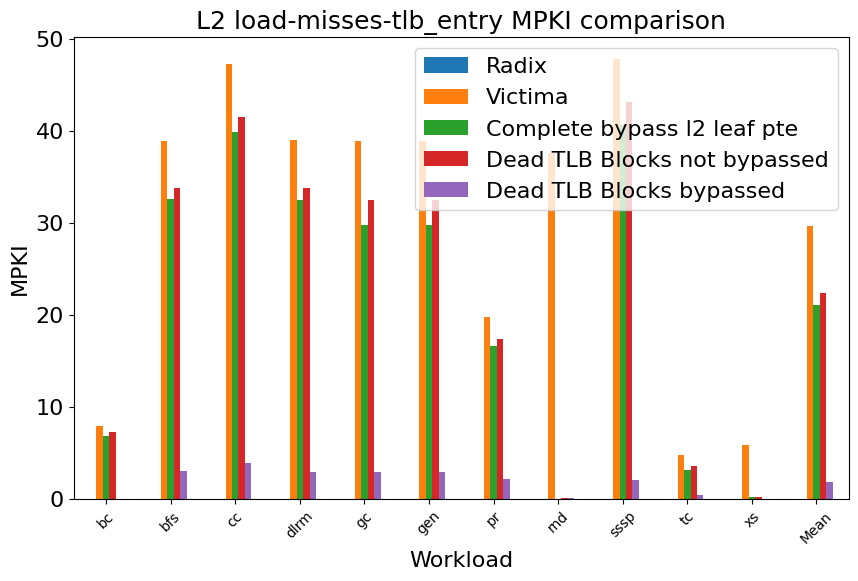

              Radix    Victima Complete bypass l2 leaf pte  \
Workload                                                     
bc            11.62      10.69                         8.6   
bfs           53.25      39.17                       33.81   
cc            64.68      47.61                        41.5   
dlrm          53.93      39.17                       33.78   
gc            58.02      51.14                       37.64   
gen           58.08      51.12                        37.7   
pr            26.09      18.96                       16.75   
rnd            53.4      29.42                        0.03   
sssp          70.43      64.27                       52.38   
tc             5.67       4.46                        3.19   
xs            10.17       4.05                        0.25   
Mean      42.303636  32.732727                   24.148182   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
b

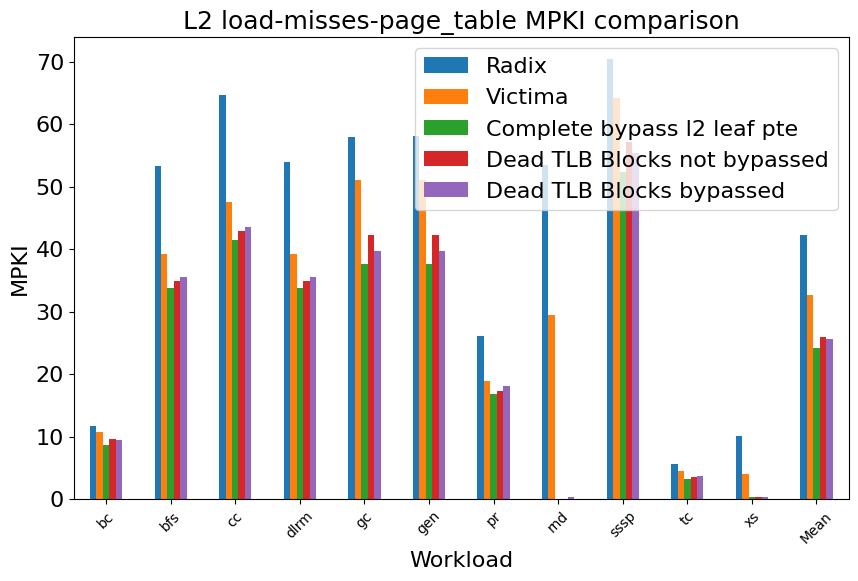

               Radix     Victima Complete bypass l2 leaf pte  \
Workload                                                       
bc             23.52       23.52                       23.52   
bfs           145.77      145.73                      145.85   
cc            176.48      176.46                      176.61   
dlrm          145.76      145.73                      145.85   
gc            131.69      131.69                      131.69   
gen           131.69      131.69                      131.69   
pr            131.11      131.11                       131.1   
rnd            77.83       77.83                       77.79   
sssp          152.93       152.9                      152.89   
tc             20.19       20.19                       20.19   
xs             37.99       37.99                       37.99   
Mean      106.814545  106.803636                  106.833636   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                              

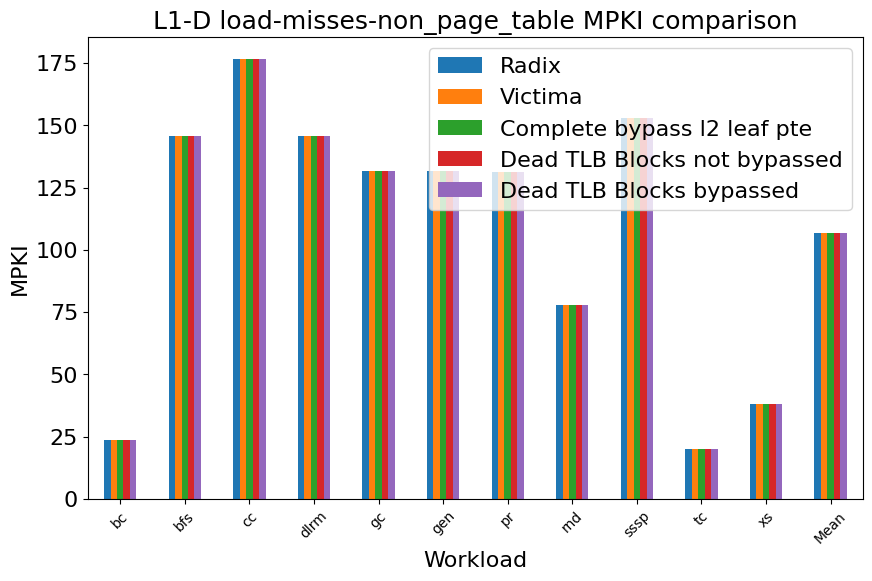

In [18]:
# Plot the comparison of different types of MPKI for different configurations

def plot_MPKI_comparison(cache_name, miss_type, get_mpki_func=get_cache_mpki):
    mpkis = []
    for df in data_dfs:
        mpkis.append(get_mpki_func(df, cache_name, miss_type))

    cmp = compare(mpkis, headings)

    cmp.index = workloads + ['Mean']
    cmp.index.name = 'Workload'

    print(cmp)

    cmp.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('MPKI')
    plt.xticks(rotation=45, fontsize=10)
    plt.title(f'{cache_name} {miss_type} MPKI comparison')
    plt.show()

    return cmp


d1 = plot_MPKI_comparison('L2', MISSES_DATA_BLOCKS)
d2 = plot_MPKI_comparison('L2', MISSES_TLB_BLOCKS)
d3 = plot_MPKI_comparison('L2', MISSES_PTE_BLOCKS)

d4 = plot_MPKI_comparison('L1-D', MISSES_DATA_BLOCKS)



d1.to_csv('res/MPKI/L2 Data Blocks MPKI.csv')
d2.to_csv('res/MPKI/L2 TLB Blocks MPKI.csv')
d3.to_csv('res/MPKI/L2 PTE Blocks MPKI.csv')
d4.to_csv('res/MPKI/L1 Data Blocks MPKI.csv')



d1.to_csv('l2_data_mpkis.csv')
d2.to_csv('l2_tlb_block_mpkis.csv')
d3.to_csv('l2_pte_mpkis.csv')
d4.to_csv('l1_data_mpkis.csv')



## NUCA Cache analysis

               Radix     Victima Complete bypass l2 leaf pte  \
Workload                                                       
bc             27.69       27.79                       27.65   
bfs           146.92      146.96                      146.92   
cc            173.94       174.0                      173.95   
dlrm          146.92      146.96                      146.92   
gc            120.79      121.83                      119.62   
gen           120.79      121.82                      119.62   
pr            130.11      130.13                      130.12   
rnd            75.98        76.0                       75.89   
sssp          150.73      151.29                       150.7   
tc             20.06       20.07                       20.06   
xs             33.64       33.63                       33.35   
Mean      104.324545  104.589091                  104.072727   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                              

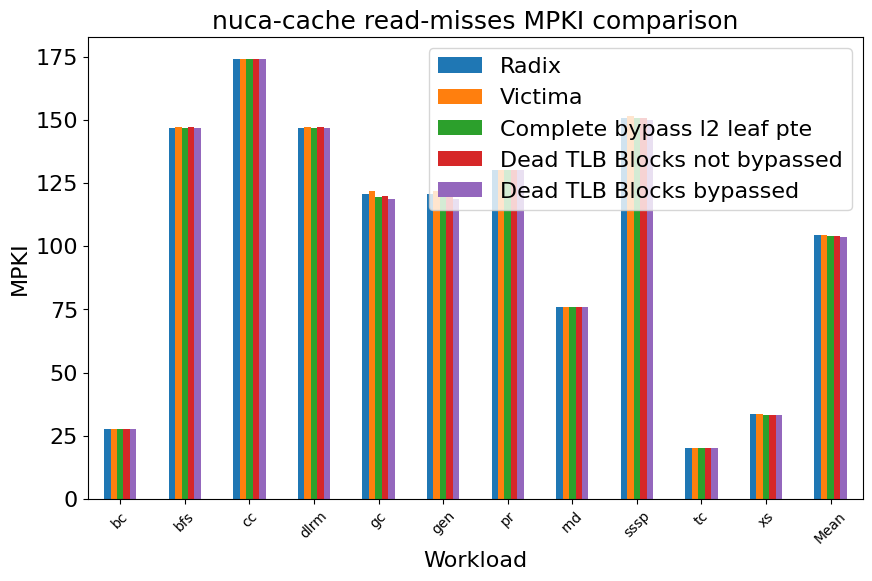

             Radix   Victima Complete bypass l2 leaf pte  \
Workload                                                   
bc            3.93      3.53                         0.0   
bfs           0.11      0.09                         0.0   
cc            0.13      0.11                         0.0   
dlrm          0.11      0.09                         0.0   
gc             0.0       0.0                         0.0   
gen            0.0       0.0                         0.0   
pr            0.05      0.03                         0.0   
rnd           4.79      1.46                        0.05   
sssp          0.03      0.03                         0.0   
tc             0.0       0.0                         0.0   
xs             0.0       0.0                         0.0   
Mean      0.831818  0.485455                    0.004545   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
bc                           

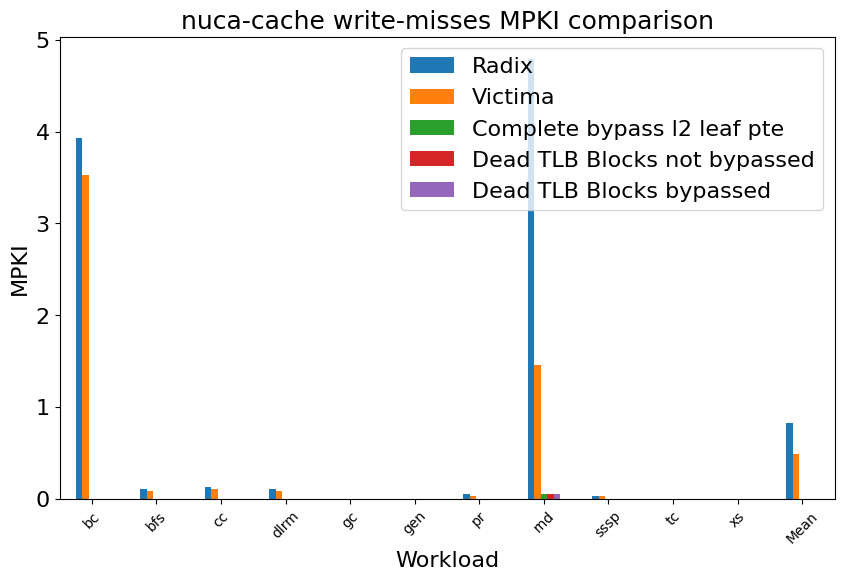

              Radix    Victima Complete bypass l2 leaf pte  \
Workload                                                     
bc            11.01      18.11                        15.4   
bfs           47.16      75.69                       65.85   
cc            56.94       92.1                       80.72   
dlrm          47.62      75.73                       65.77   
gc            49.94      83.21                       66.77   
gen           49.93      83.18                       66.81   
pr            24.02      37.96                       33.23   
rnd           47.76      58.27                        0.07   
sssp          65.48     108.32                        92.4   
tc             5.24       8.85                        6.35   
xs              7.6       7.77                         0.5   
Mean      37.518182  59.017273                   44.897273   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
b

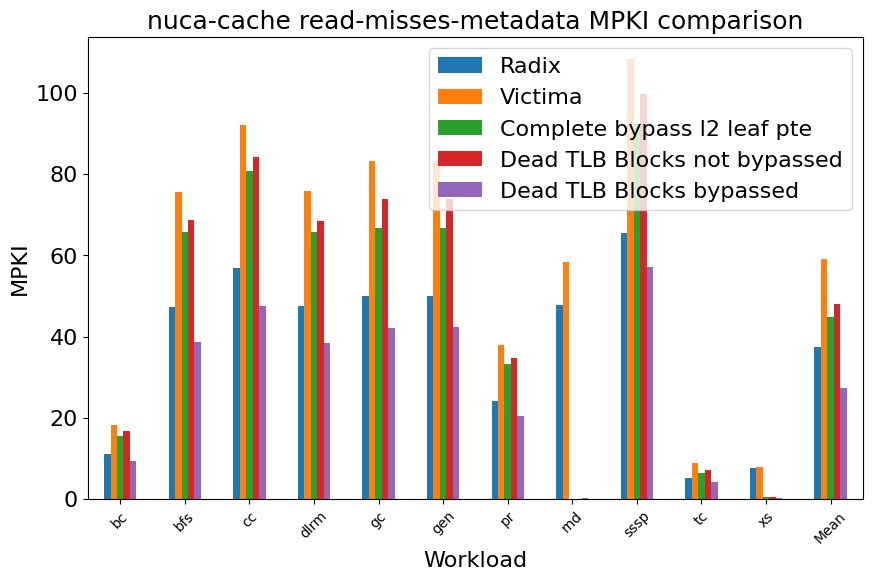

         Radix Victima Complete bypass l2 leaf pte  \
Workload                                             
bc         0.0     0.0                         0.0   
bfs        0.0     0.0                         0.0   
cc         0.0     0.0                         0.0   
dlrm       0.0     0.0                         0.0   
gc         0.0     0.0                         0.0   
gen        0.0     0.0                         0.0   
pr         0.0     0.0                         0.0   
rnd        0.0     0.0                         0.0   
sssp       0.0     0.0                         0.0   
tc         0.0     0.0                         0.0   
xs         0.0     0.0                         0.0   
Mean       0.0     0.0                         0.0   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
bc                                0.0                      0.0  
bfs                               0.0           

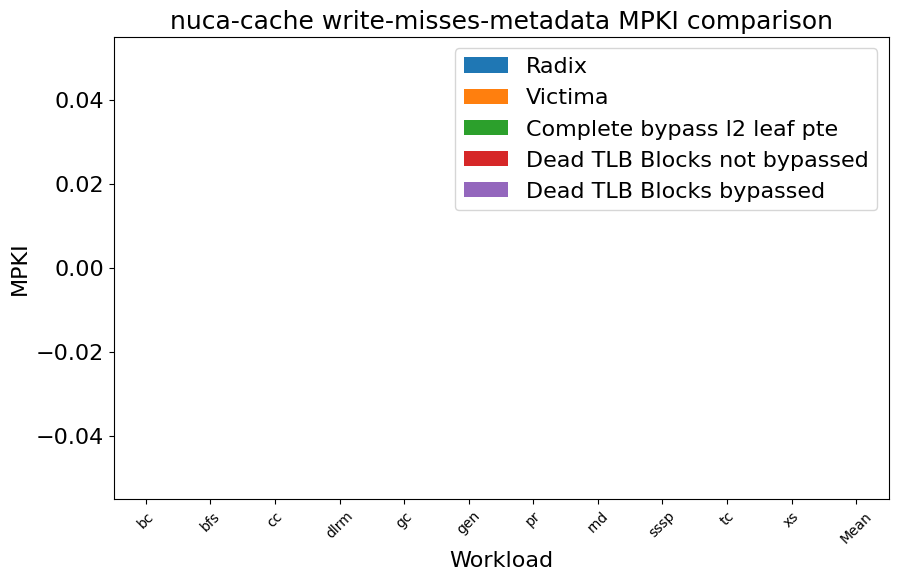

           Radix     Victima Complete bypass l2 leaf pte  \
Workload                                                   
bc         26.27       25.32                       19.85   
bfs       178.24       169.7                      164.33   
cc         218.2       208.2                      202.06   
dlrm       178.7      169.71                       164.3   
gc        165.76      164.28                      151.87   
gen       165.74      164.26                      151.92   
pr        116.64      111.48                      109.16   
rnd        52.52       29.71                        0.08   
sssp      210.11      207.22                      196.46   
tc         22.53        21.7                       20.46   
xs         41.17       37.45                       33.53   
Mean      125.08  119.002727                  110.365455   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
bc                           

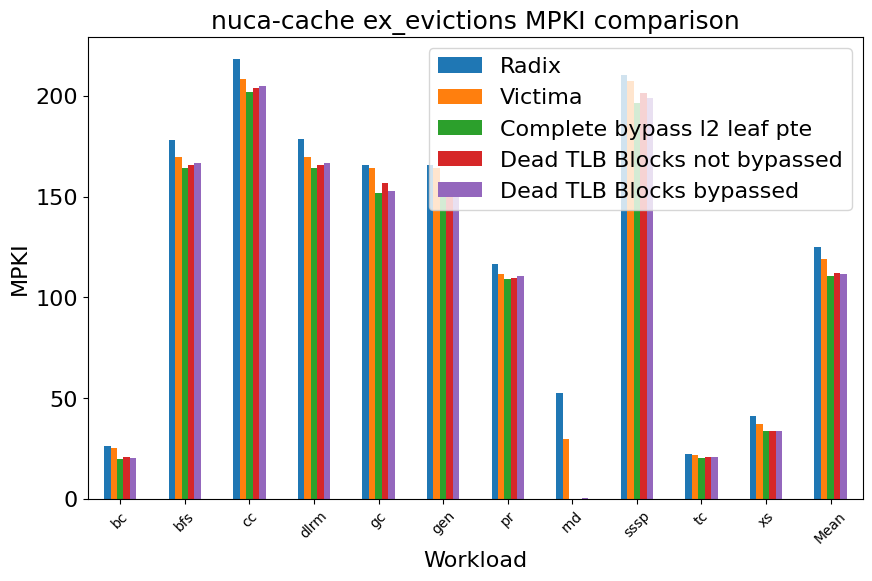

              Radix    Victima Complete bypass l2 leaf pte  \
Workload                                                     
bc            16.29      16.31                        16.3   
bfs           15.88      15.88                       15.88   
cc            12.74      12.74                       12.74   
dlrm          15.88      15.88                       15.88   
gc             4.91       4.91                        4.91   
gen            4.91       4.91                        4.91   
pr            37.47      37.48                       37.48   
rnd           75.95      75.96                       75.82   
sssp           6.07       6.08                        6.06   
tc             2.71       2.71                        2.71   
xs              0.0        0.0                         0.0   
Mean      17.528182  17.532727                   17.517273   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
b

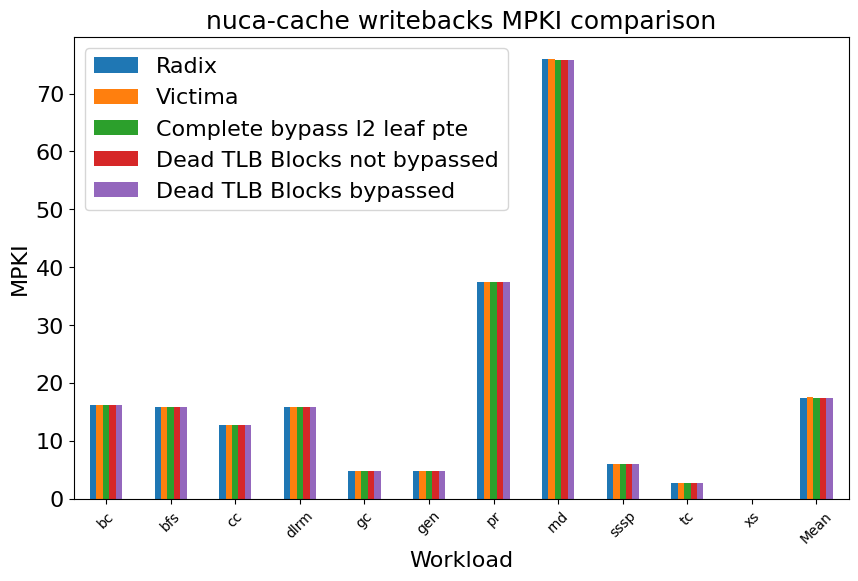

              Radix    Victima Complete bypass l2 leaf pte  \
Workload                                                     
bc            11.62      18.62                       15.45   
bfs           53.25      78.11                       66.37   
cc            64.68      94.86                       81.37   
dlrm          53.93      78.14                       66.28   
gc            58.02      90.02                       67.37   
gen           58.08      89.98                       67.43   
pr            26.09      38.71                       33.41   
rnd            53.4      67.06                        0.07   
sssp          70.43     112.08                       92.97   
tc             5.67       9.27                        6.39   
xs            10.17        9.9                         0.5   
Mean      42.303636  62.431818                   45.237273   

         Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
Workload                                                        
b

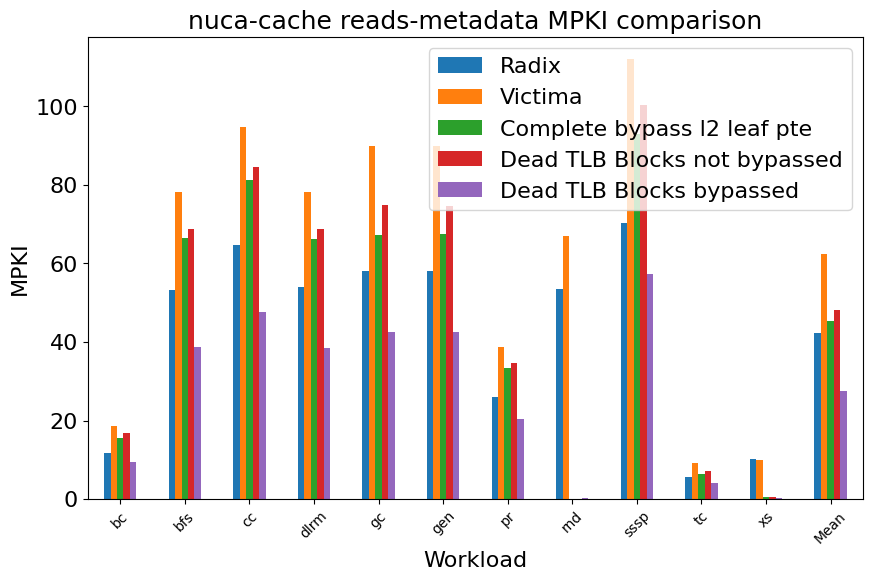

In [19]:
MISSES_READ_DATA_NUCA = 'read-misses'
MISSES_READ_METADATA_NUCA = 'read-misses-metadata'
MISSES_WRITE_DATA_NUCA = 'write-misses'
MISSES_WRITE_METADATA_NUCA = 'write-misses-metadata'

READS_METADATA_NUCA = 'reads-metadata'


EX_EVICTIONS = 'ex_evictions'
WRITEBACKS = 'writebacks'



def get_llc_mpki(df, cache_name, misses_name):
    label = f'LLC {misses_name} MPKI'

    mpki = pd.DataFrame(index=[label], columns=workloads)
    attr = cache_name + '.' + misses_name

    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][attr] / df[wl]['core.instructions'] * 1000, 2)

    return mpki.T

d1 = plot_MPKI_comparison('nuca-cache', MISSES_READ_DATA_NUCA, get_llc_mpki)
d2 = plot_MPKI_comparison('nuca-cache', MISSES_WRITE_DATA_NUCA, get_llc_mpki)
d3 = plot_MPKI_comparison('nuca-cache', MISSES_READ_METADATA_NUCA, get_llc_mpki)
d4 = plot_MPKI_comparison('nuca-cache', MISSES_WRITE_METADATA_NUCA, get_llc_mpki)
d8 = plot_MPKI_comparison('nuca-cache', EX_EVICTIONS, get_llc_mpki)
d9 = plot_MPKI_comparison('nuca-cache', WRITEBACKS, get_llc_mpki)
d11 = plot_MPKI_comparison('nuca-cache', READS_METADATA_NUCA, get_llc_mpki)

d5 = d1 + d2
d6 = d3 + d4

d7 = d5 + d6

d10 = d8 + d9

final = [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10]
names = [
    'LLC Read Data MPKI',
    'LLC Write Data MPKI',
    'LLC Read MetaData MPKI',
    'LLC Write MetaData MPKI', 
    'LLC Total Data MPKI', 
    'LLC Total Metadata MPKI', 
    'LLC Total MPKI',
    'LLC Evictions EX State',
    'LLC Writebacks',
    'LLC Total Evictions',
]


for d, name in zip(final, names):
    d.index = workloads + ['Mean']
    d.index.name = 'Workload'
    d.to_csv(f'res/MPKI/{name}.csv')




## The REUSE values!
Note that the reuse is recorded after the blocks are evicted!

In [20]:
DATA_REUSE = 'data'
PTE_REUSE = 'metadata'
TLB_REUSE = 'tlb'

def get_reuse_attrs(cache_name, type):
    return [f'{cache_name}.{type}-reuse-{i}' for i in range(5)]

def get_cache_reuse(df, cache_name, type):
    attrs = get_reuse_attrs(cache_name, type)

    # Initialize DataFrame properly with attributes as rows and workloads as columns
    reuse = pd.DataFrame(index=attrs, columns=workloads)

    for wl in workloads:
        for attr in attrs:
            reuse.at[attr, wl] = df[wl][attr]  # Assign values correctly

    reuse = reuse.T

    # now calculate the percentage of each reuse level
    for wl in workloads:
        total = reuse.loc[wl].sum()
        for attr in attrs:
            reuse.at[wl, attr] = round(reuse.at[wl, attr] / total * 100, 2)

    # add a row for mean values rounded to 2 decimal points
    reuse.loc['mean'] = reuse.mean()

    return reuse  # Transpose to maintain workload as rows


def plot_reuse(df_inp, cache_name, type, heading):
    d1 = get_cache_reuse(df_inp, cache_name, type)

    # Define custom colors
    # colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
    # define 5 levels of colors for each reuse level starting from gray and going to green
    # colors = ["#808080", "#6666bb", "#C0C0C0", "#D3D3D3", "#77bb77"]

    #rename the columns
    d1.columns = ['Reuse 0', 'Reuse 1-5', 'Reuse 6-10', 'Reuse 11-20', 'Reuse >20']

    d1.index = workloads + ['Mean']
    d1.index.name = 'Workload'

    
    print(f'Creating reuse-{heading}-{type}.csv')
    d1.to_csv(f'reuse-{heading}-{type}.csv')

    d1.to_csv(f'res/Reuse/{heading}-{cache_name}-{type}.csv')


    # Plot stacked bar chart
    ax = d1.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
    # ax = d1.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)

    # Labels and title
    plt.ylabel("Percentage")
    plt.xlabel("Workload")
    plt.title(heading, pad=45)

    #rotate x labels
    plt.xticks(rotation=45)

    # Add legend outside
    # plt.legend(title="Reuse Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(d1.columns), fontsize=14)

    
    # set y limit to 100
    plt.ylim(0, 100)
    # plt.title(heading)

    # Show plot
    plt.tight_layout()
    plt.show()


In [21]:
def get_reuse_plots(df, cache_name, type, heading):
    # Plot reuse for each configuration
    for i in range(len(df)):
        plot_reuse(df[i], cache_name, type, heading[i])

### Data Blocks reuse in L2

Data Reuse
Creating reuse-Radix-data.csv


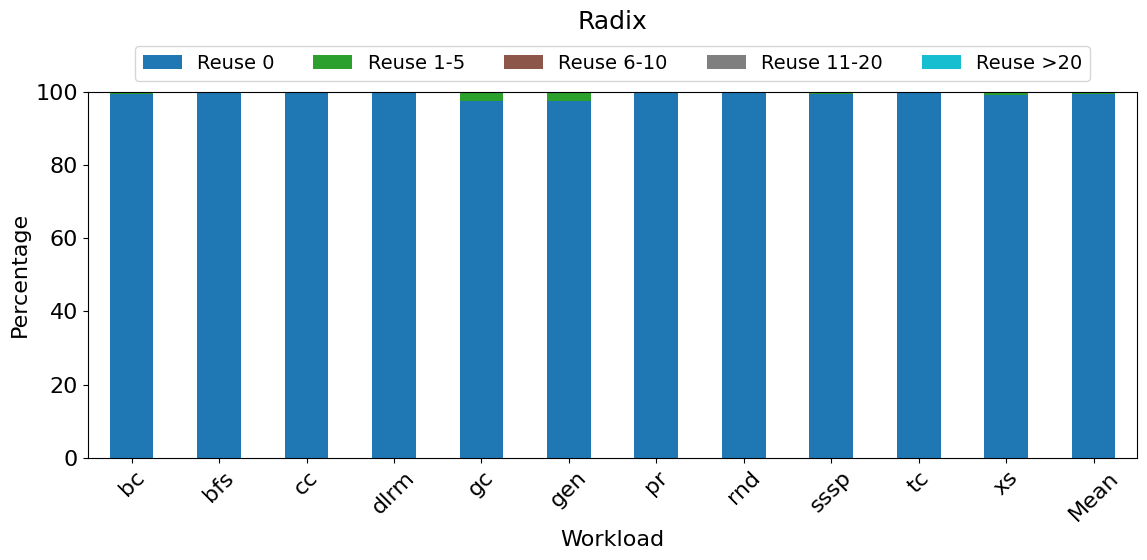

Creating reuse-Victima-data.csv


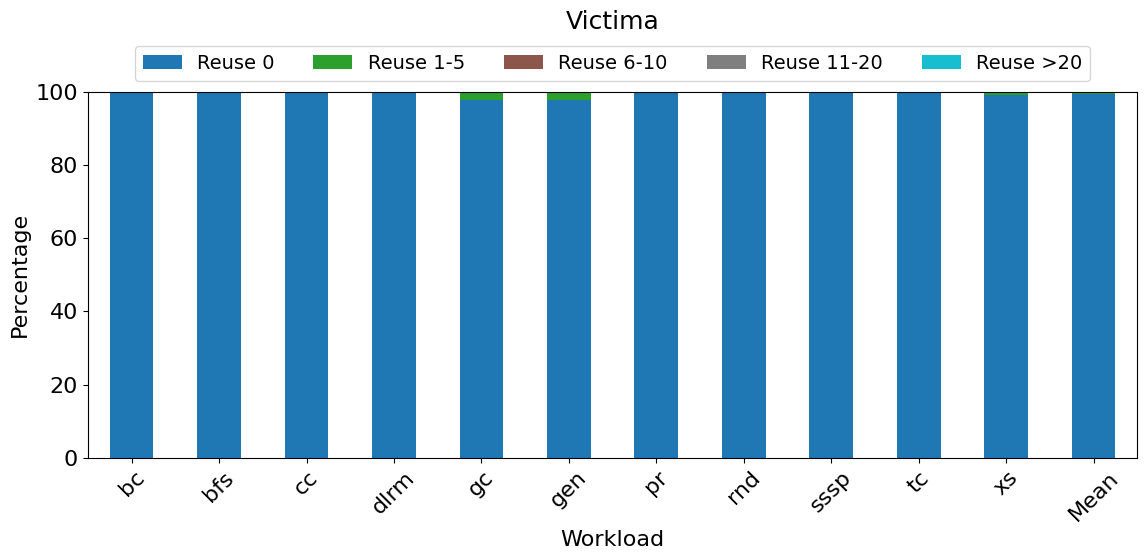

Creating reuse-Complete bypass l2 leaf pte-data.csv


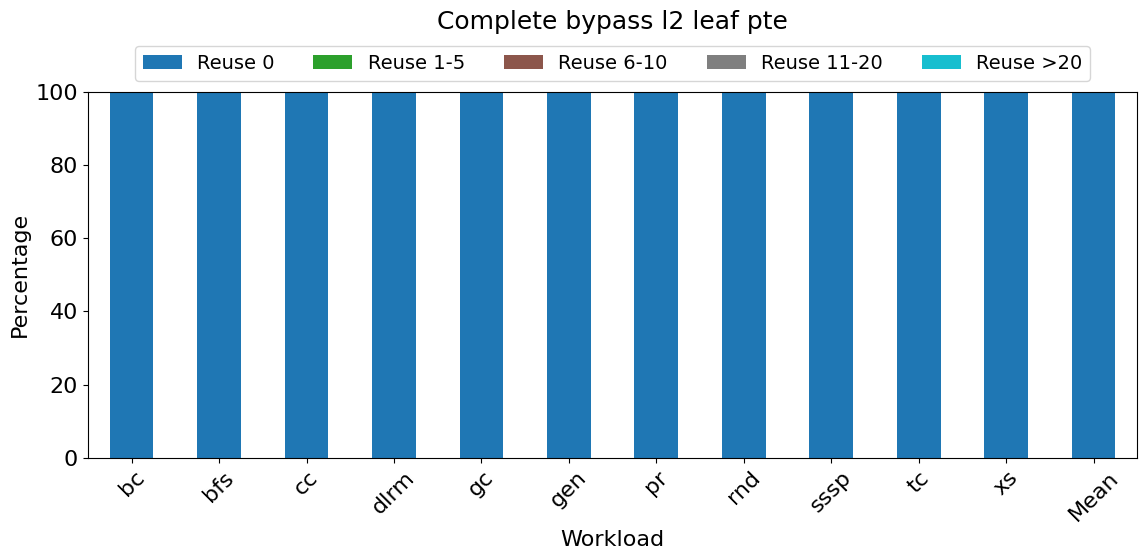

Creating reuse-Dead TLB Blocks not bypassed-data.csv


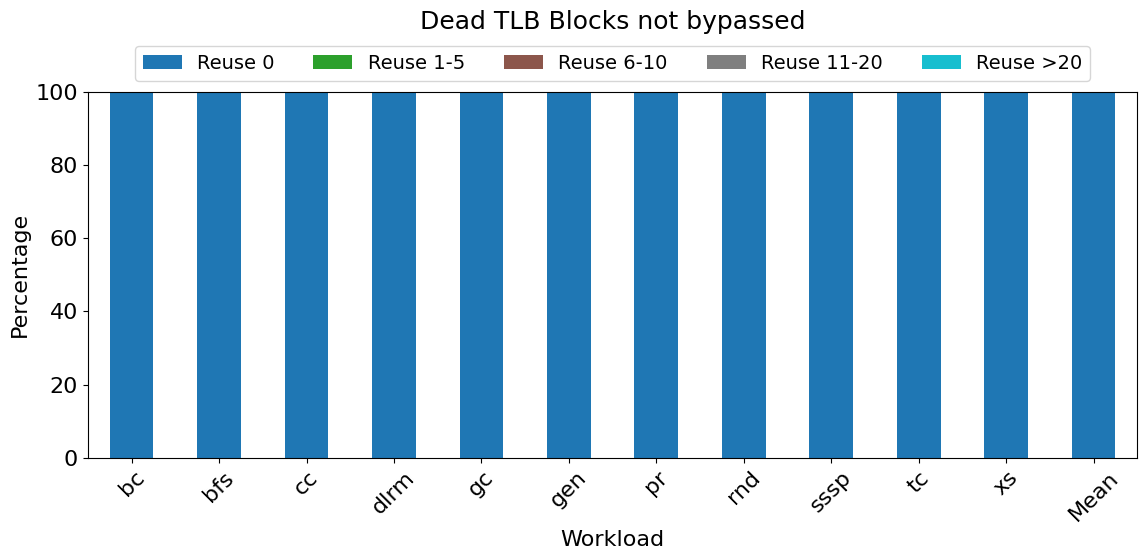

Creating reuse-Dead TLB Blocks bypassed-data.csv


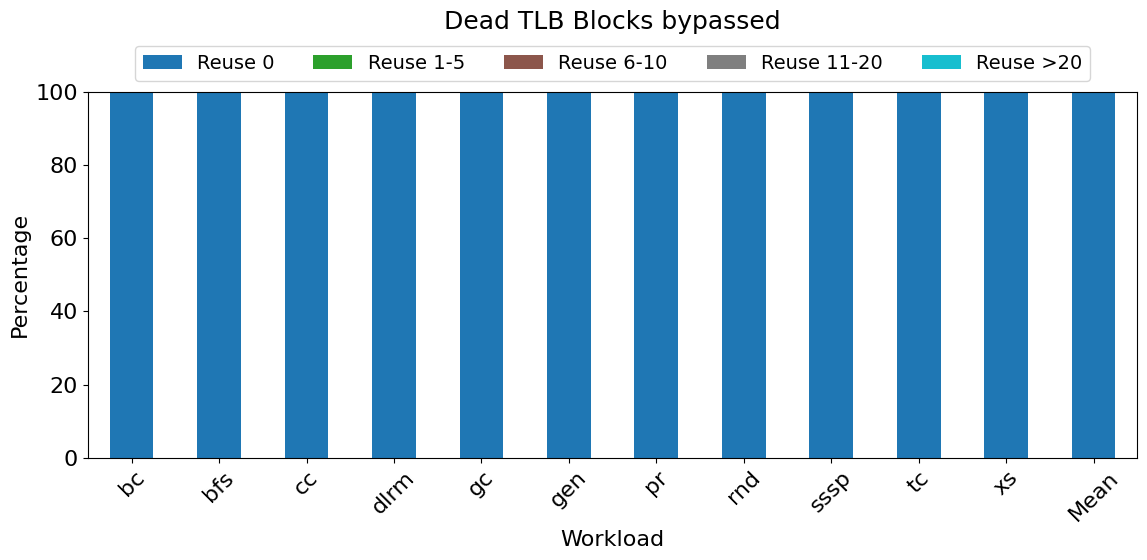

In [22]:
print("Data Reuse")
for i in range(len(data_dfs)):
    plot_reuse(data_dfs[i], 'L2', DATA_REUSE, headings[i])

### PTE Blocks reuse in L2

PTE Reuse
Creating reuse-Radix-metadata.csv


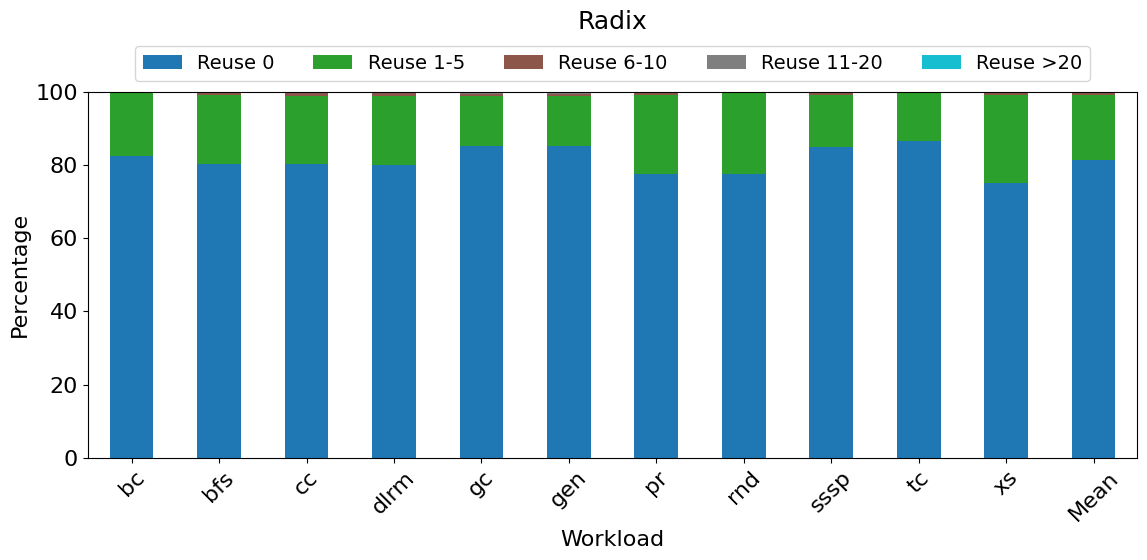

Creating reuse-Victima-metadata.csv


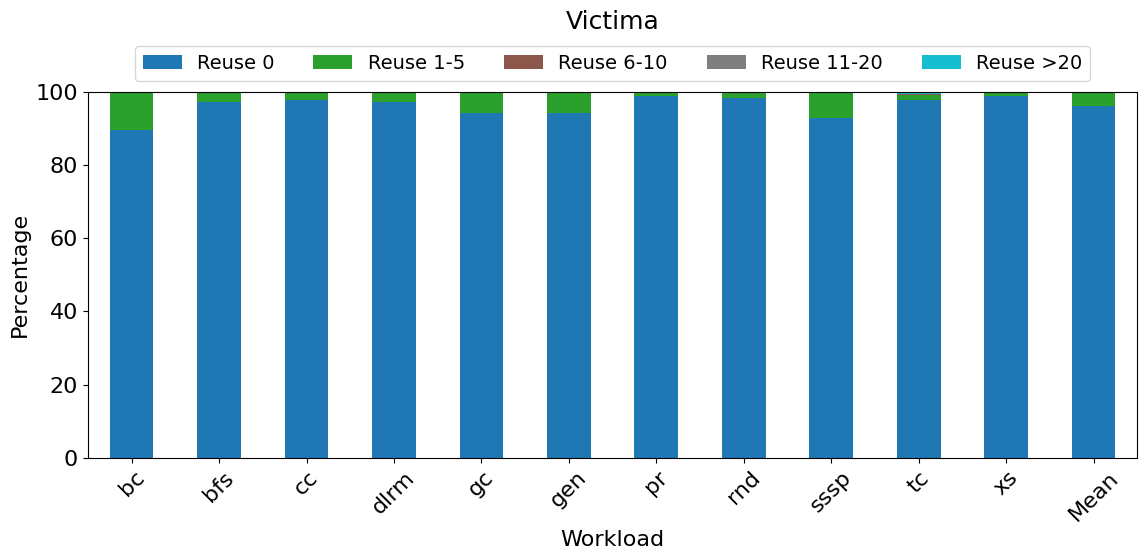

Creating reuse-Complete bypass l2 leaf pte-metadata.csv


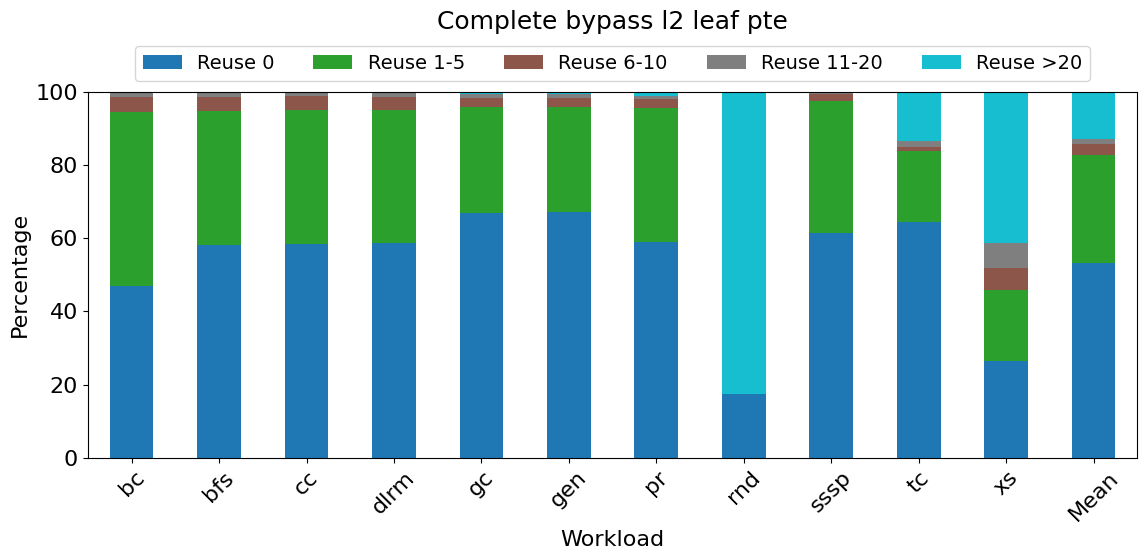

Creating reuse-Dead TLB Blocks not bypassed-metadata.csv


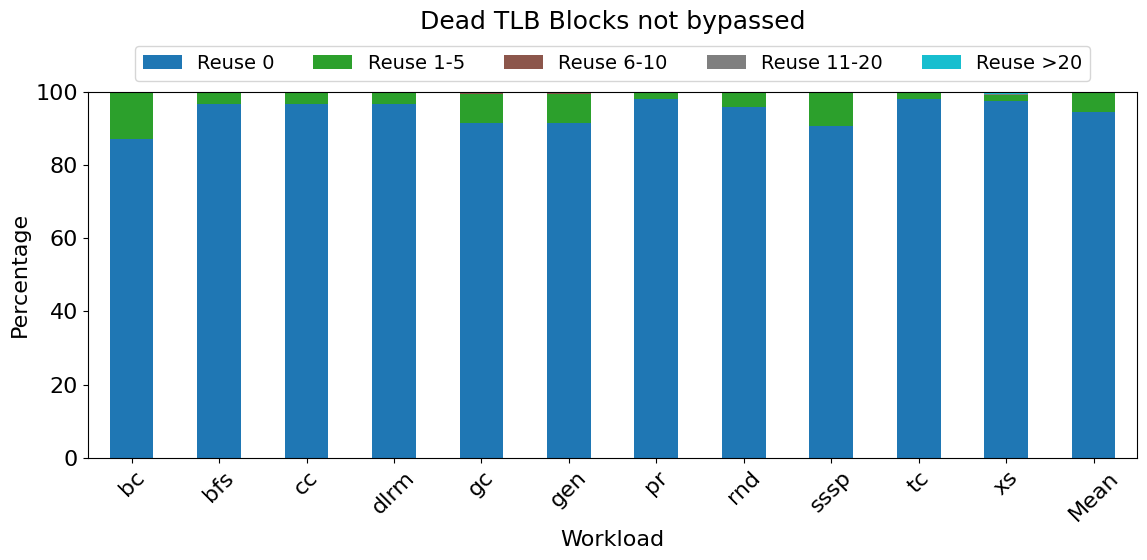

Creating reuse-Dead TLB Blocks bypassed-metadata.csv


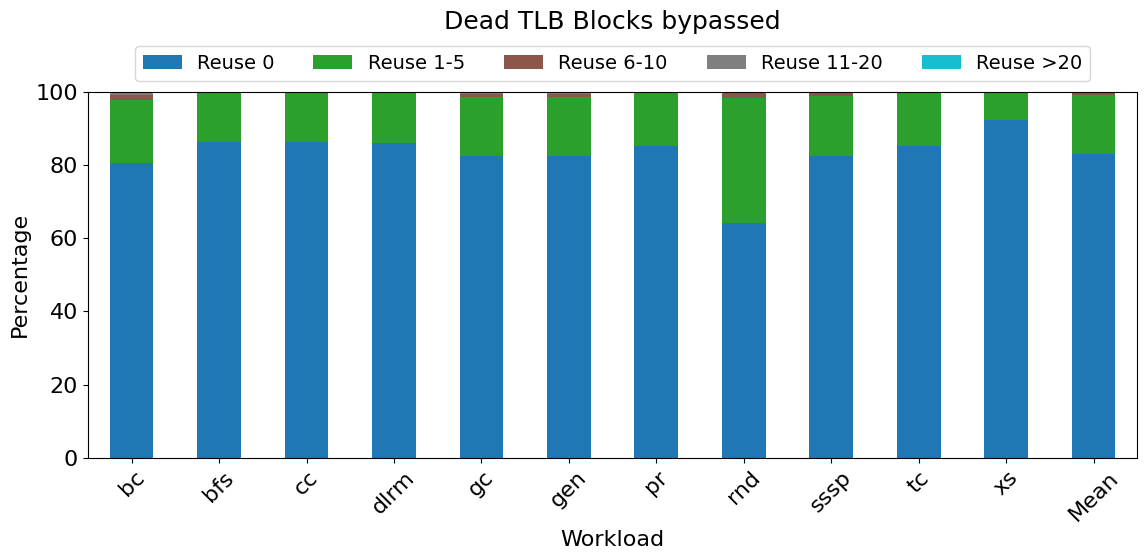

In [23]:
print("PTE Reuse")
for i in range(len(data_dfs)):
    plot_reuse(data_dfs[i], 'L2', PTE_REUSE, headings[i])

### TLB Blocks Reuse in L2

TLB Reuse
Creating reuse-Radix-tlb.csv


/tmp/ipykernel_168005/4007289981.py:24: RuntimeWarning: invalid value encountered in scalar divide
  reuse.at[wl, attr] = round(reuse.at[wl, attr] / total * 100, 2)


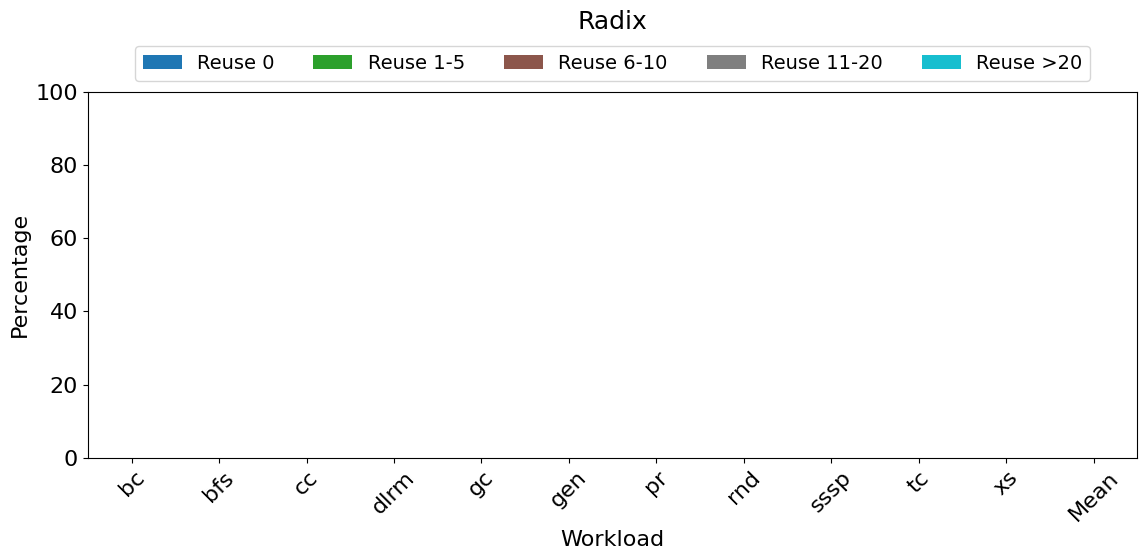

Creating reuse-Victima-tlb.csv


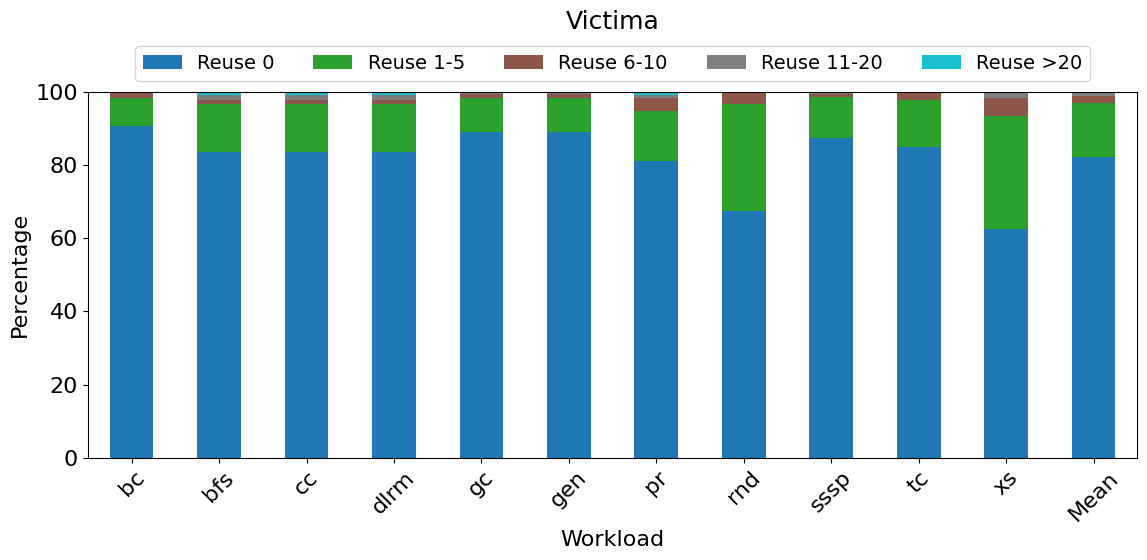

Creating reuse-Complete bypass l2 leaf pte-tlb.csv


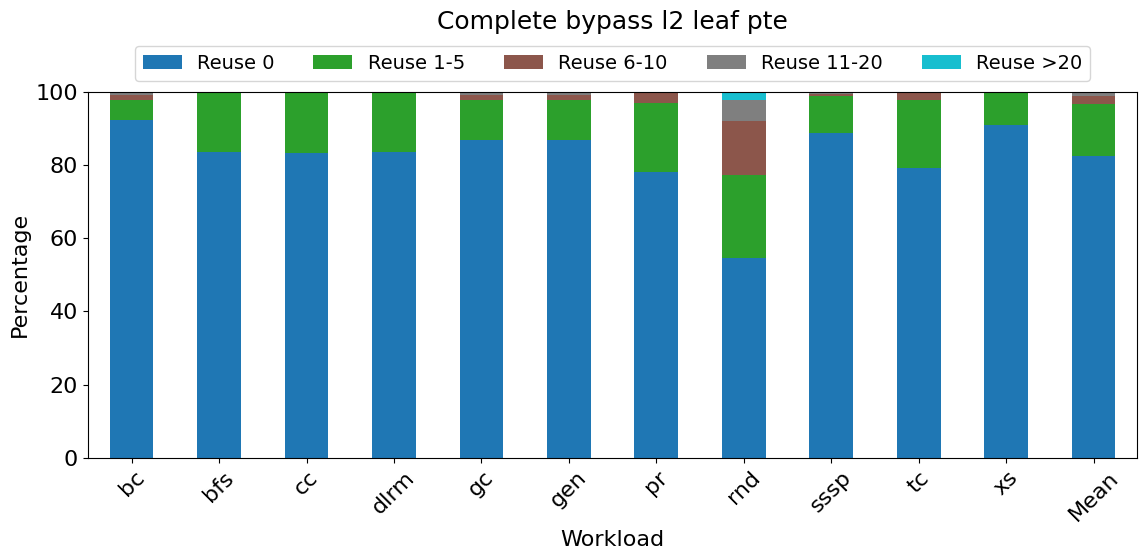

Creating reuse-Dead TLB Blocks not bypassed-tlb.csv


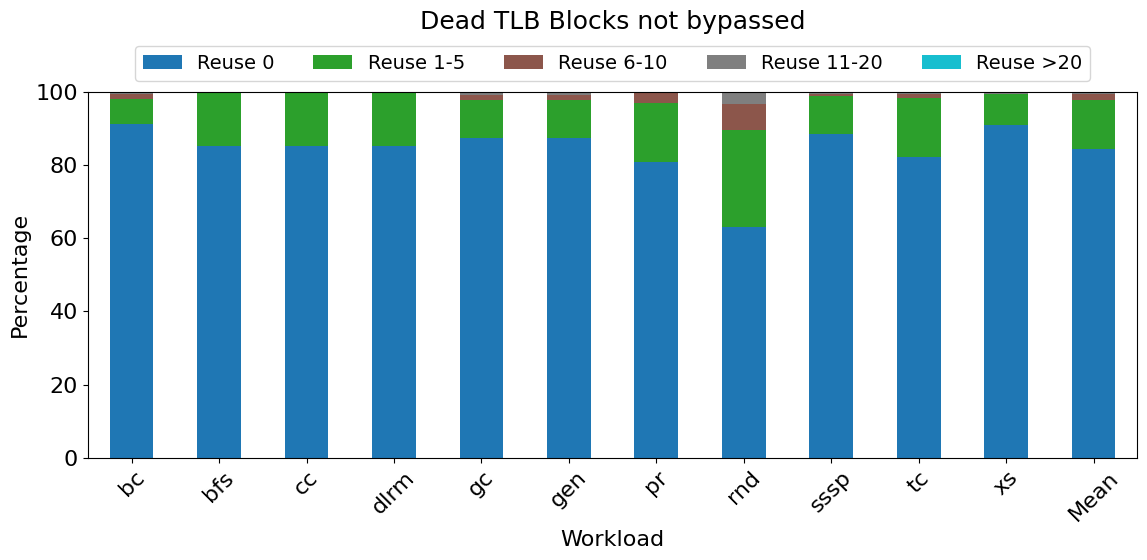

Creating reuse-Dead TLB Blocks bypassed-tlb.csv


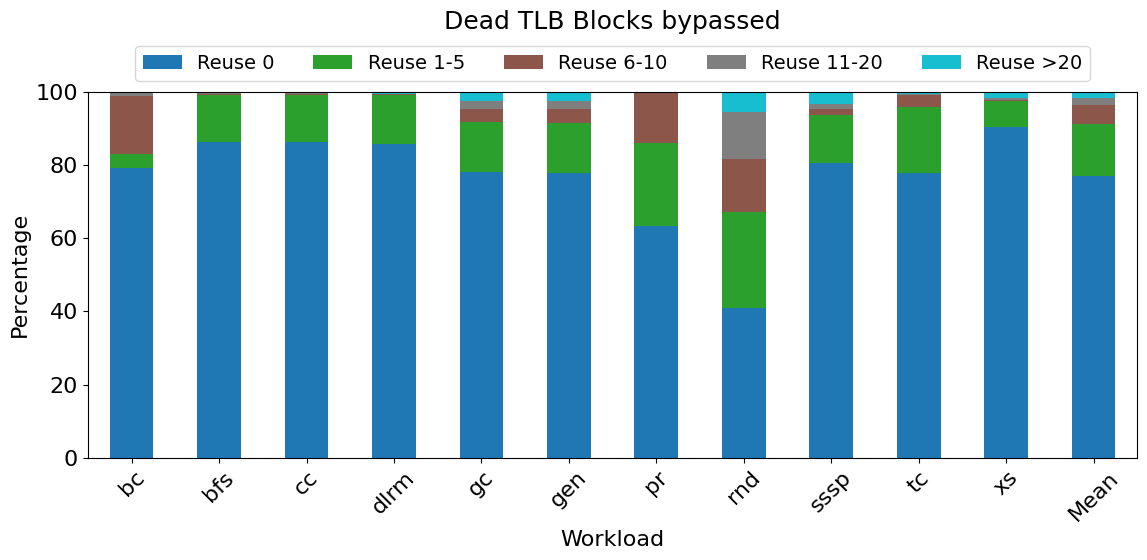

In [24]:
print("TLB Reuse")
for i in range(len(data_dfs)):
    plot_reuse(data_dfs[i], 'L2', TLB_REUSE, headings[i])

## Data Blocks Reuse for NUCA cache

Creating reuse-Radix-data.csv


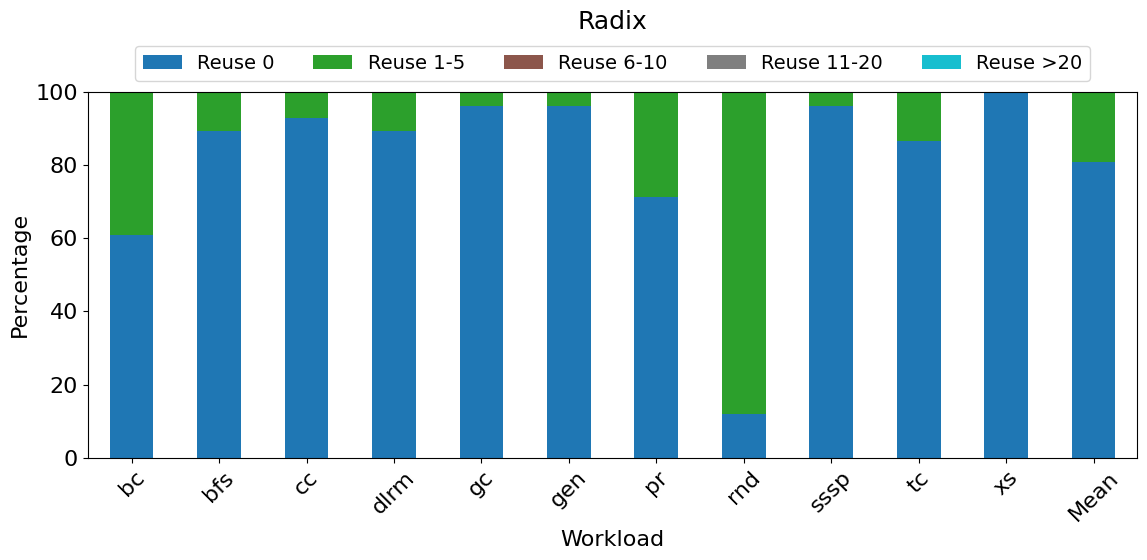

Creating reuse-Victima-data.csv


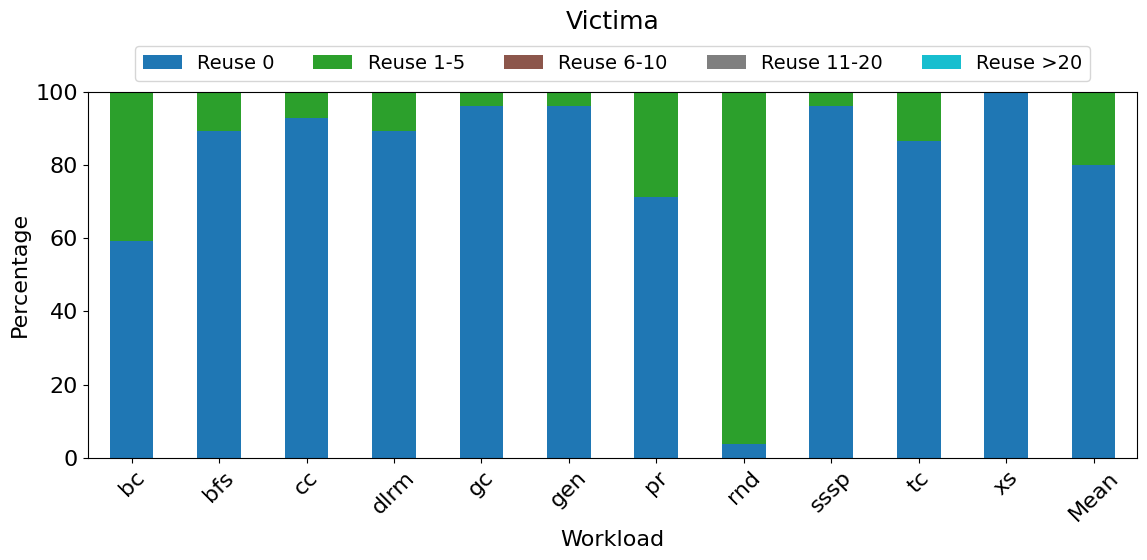

Creating reuse-Complete bypass l2 leaf pte-data.csv


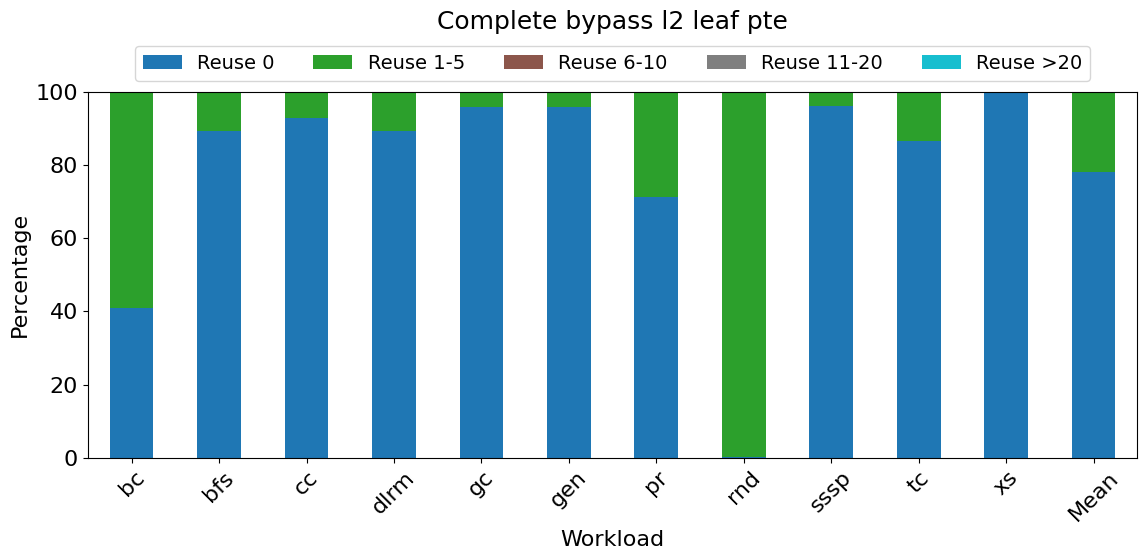

Creating reuse-Dead TLB Blocks not bypassed-data.csv


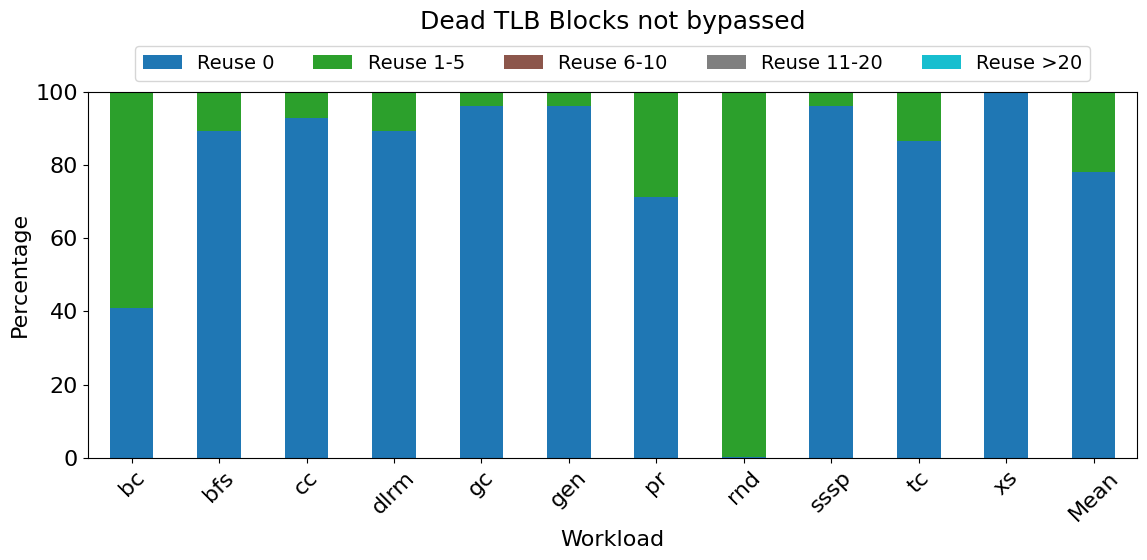

Creating reuse-Dead TLB Blocks bypassed-data.csv


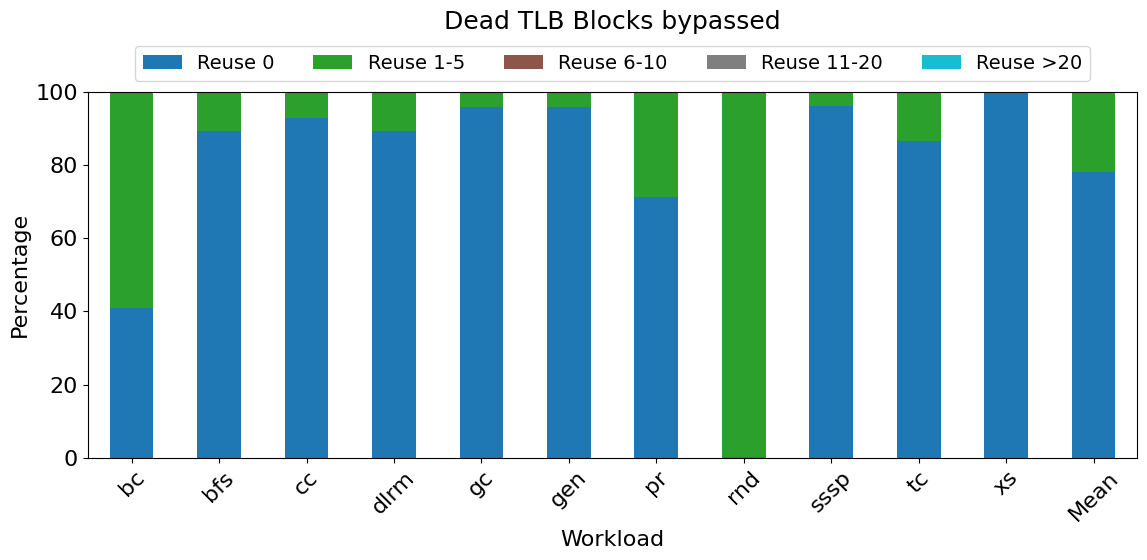

In [25]:
d1 = get_reuse_plots(data_dfs, 'nuca-cache', DATA_REUSE, headings)

Creating reuse-Radix-metadata.csv


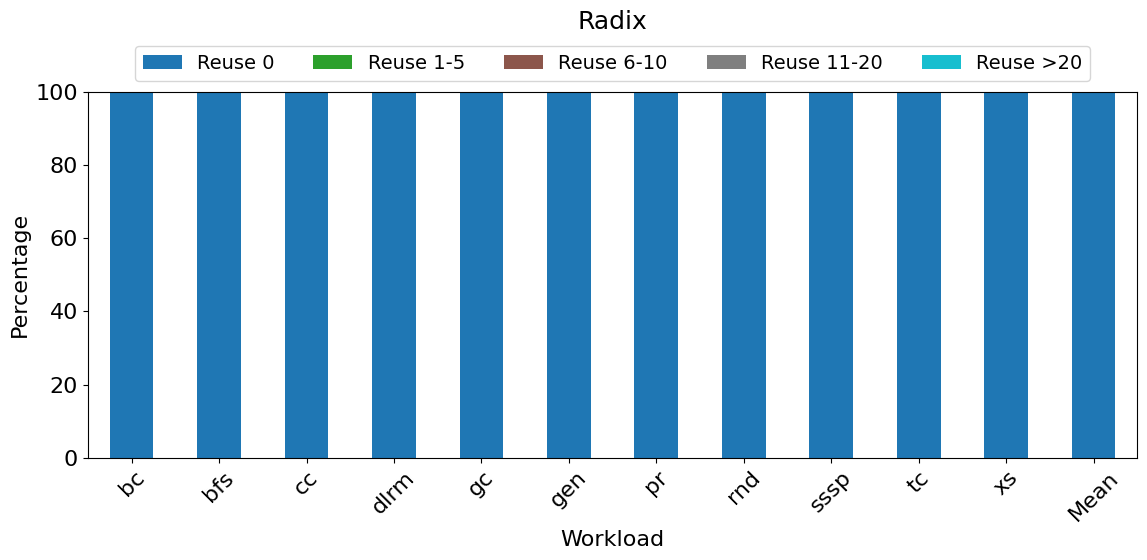

Creating reuse-Victima-metadata.csv


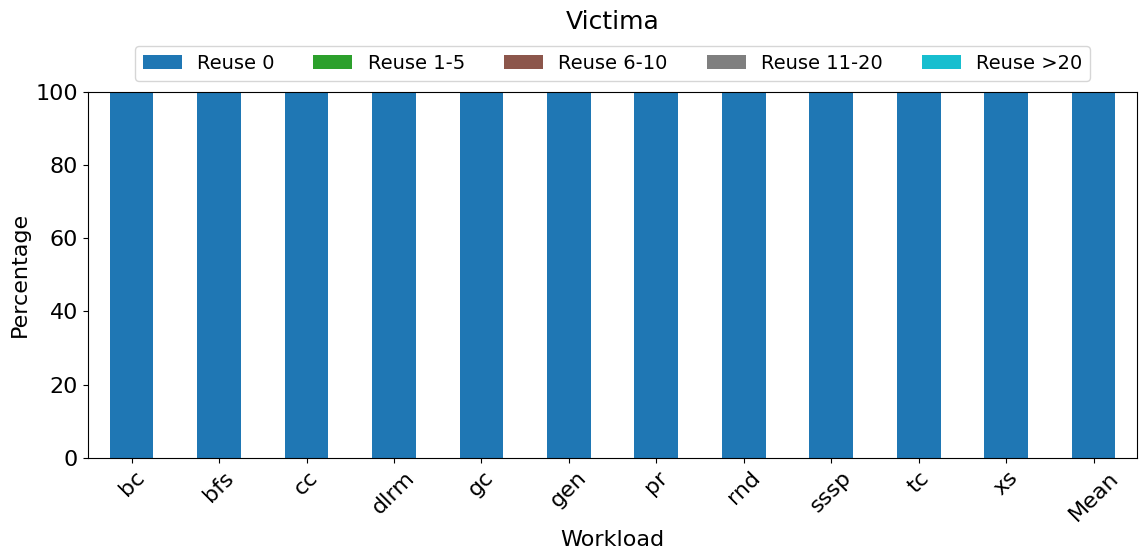

Creating reuse-Complete bypass l2 leaf pte-metadata.csv


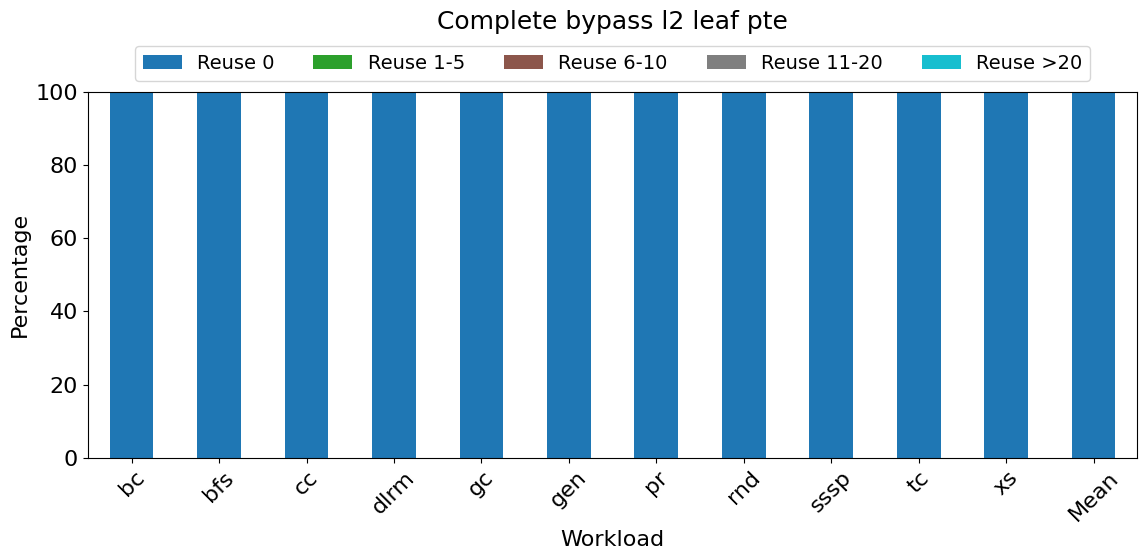

Creating reuse-Dead TLB Blocks not bypassed-metadata.csv


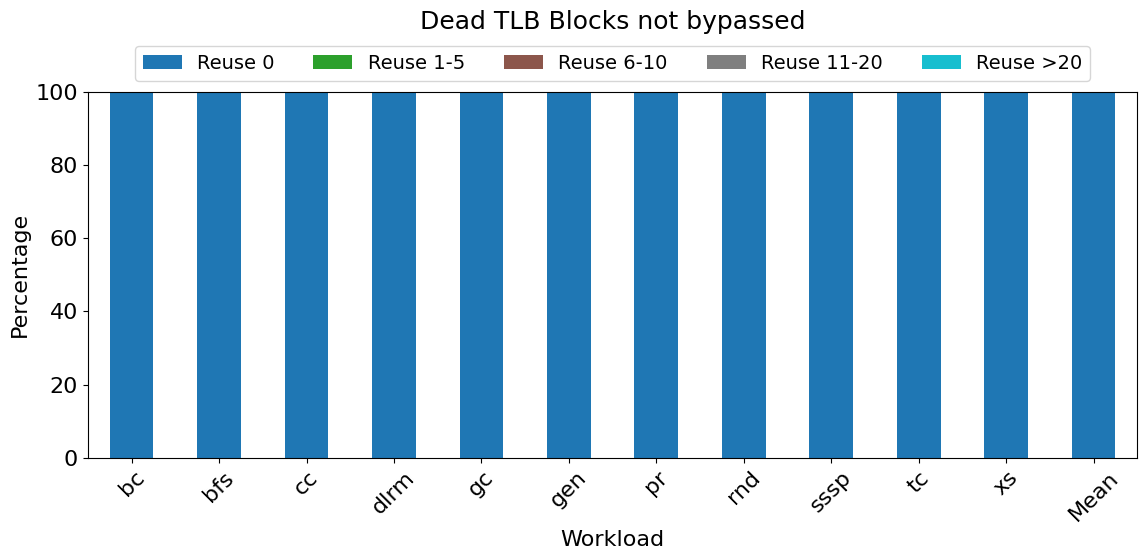

Creating reuse-Dead TLB Blocks bypassed-metadata.csv


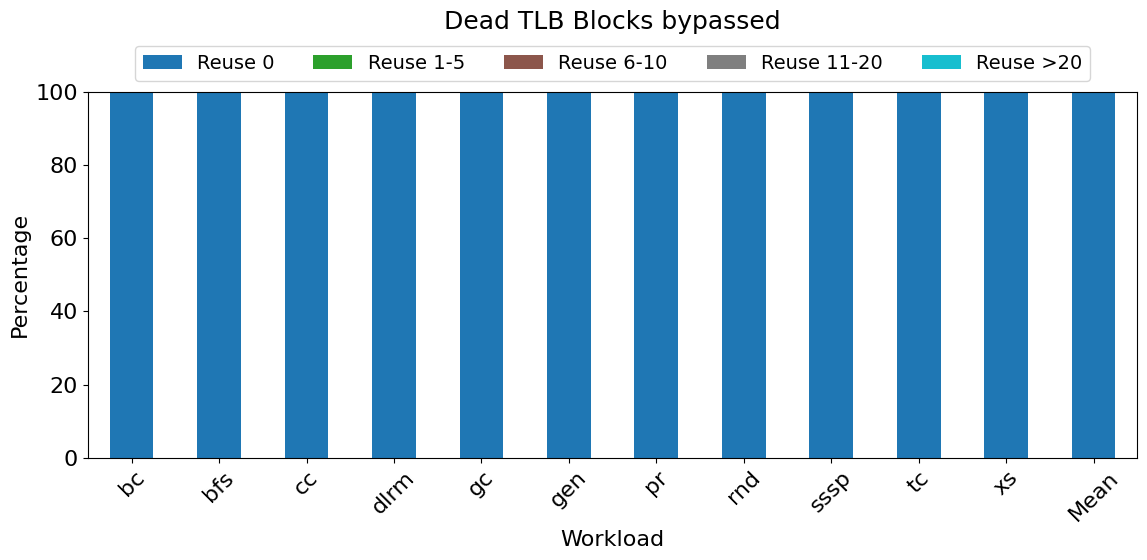

In [26]:
d1 = get_reuse_plots(data_dfs, 'nuca-cache', PTE_REUSE, headings)

## Get the IPC

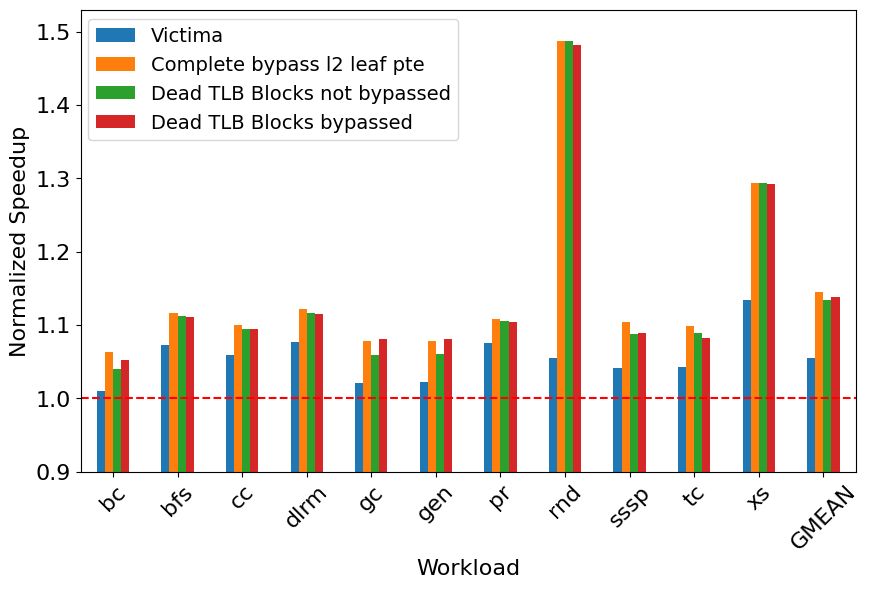

<Figure size 640x480 with 0 Axes>

In [27]:
def get_ipc(df):
    label = 'IPC'
    ipc = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        ipc.at[label, wl] = df[wl]['ipc']

    return ipc.T

def get_normalized_speedup(df_base, df_cmp, hardcode_rnd=False):
    label = 'Normalized Speedup'
    speedup = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # hardcode speedup for rnd to 1.3164
        if wl == 'rnd' and hardcode_rnd:
            speedup.at[label, wl] = 1.3164
        else:
            speedup.at[label, wl] = df_cmp[wl]['ipc'] / df_base[wl]['ipc']

    return speedup.T


# print(get_ipc(data_dfs[3]))

imps = []
for i in range(1, len(data_dfs)):
    imps.append(get_normalized_speedup(data_dfs[0], data_dfs[i]))


cmp = compare(imps, headings[1:], 'geomean')





cmp.index = workloads + ['GMEAN']
cmp.index.name = 'Workload'


# # get the max geomean speedup by taking max per row of cmp
# max_speedup = cmp.max(axis=1)

# # get geomean of max speedup except last row
# geomean = max_speedup[:-1].prod()**(1/len(max_speedup[:-1]))

# max_speedup['GMEAN'] = geomean
# print(f'Geomean of max speedup: {geomean}')


# cmp['Max Speedup'] = max_speedup


cmp.to_csv('speedup.csv')

cmp.to_csv('res/Speedup/Normalized Speedup.csv')


#plot the speedups
cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Normalized Speedup')
# plt.title('Normalized Speedup over baseline victima')

# set y min and max
plt.ylim(0.9, 1.53)

# increase the font size of the x labels
plt.xticks(rotation=45)

# highlight y = 1 on the plot
plt.axhline(y=1, color='r', linestyle='--')

# add a legend
plt.legend(loc='best', bbox_to_anchor=(0.5, 1), fontsize=14)

plt.show()

plt.savefig('res/Speedup/Normalized Speedup.png')

In [28]:
cmp

,Victima,Complete bypass l2 leaf pte,Dead TLB Blocks not bypassed,Dead TLB Blocks bypassed
Workload,,,,
bc,1.009786,1.063275,1.040205,1.051766
bfs,1.072242,1.116125,1.111436,1.110035
cc,1.058818,1.099878,1.094447,1.094868
dlrm,1.076602,1.121339,1.116372,1.114814
gc,1.020952,1.07797,1.059379,1.080474
gen,1.021574,1.078422,1.060219,1.080302
pr,1.07494,1.107441,1.105663,1.104077
rnd,1.054899,1.487315,1.487127,1.481725
sssp,1.041664,1.103981,1.087322,1.088786


## DRAM related analysis

### DRAM Traffic Analysis

In [29]:
# Analyze the dram.reads and dram.writes
def get_dram_traffic(df):
    label = 'DRAM Traffic'
    dram_traffic = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_traffic.at[label, wl] = df[wl]['dram.reads'] + df[wl]['dram.writes']

    return dram_traffic


def get_dram_reads(df):
    label = 'DRAM Reads'
    dram_reads = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_reads.at[label, wl] = df[wl]['dram.reads']

    return dram_reads


def get_dram_writes(df):
    label = 'DRAM Writes'
    dram_writes = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_writes.at[label, wl] = df[wl]['dram.writes']

    return dram_writes


def get_dram_writes_pki(df):
    label = 'DRAM Writes PKI'
    dram_writes_pki = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_writes_pki.at[label, wl] = (df[wl]['dram.writes'] / df[wl]['core.instructions']) * 1000

    return dram_writes_pki.T

In [30]:
def normalize(df_base, df_cmp, attr, title="Comparison"):
    label = title
    comparison = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        comparison.at[label, wl] = df_cmp[wl][attr] / df_base[wl][attr]

    return comparison.T


drts = [] 
drrs = [] 
drws = []
drwpki = []
for df in data_dfs:
    drts.append(get_dram_traffic(df))
    drrs.append(get_dram_reads(df))
    drws.append(get_dram_writes(df))
    drwpki.append(get_dram_writes_pki(df))



     Victima Complete bypass l2 leaf pte Dead TLB Blocks not bypassed  \
bc       1.0                    0.937741                     0.968249   
bfs      1.0                    0.955631                     0.968068   
cc       1.0                    0.957062                     0.970426   
dlrm     1.0                    0.955085                       0.9677   
gc       1.0                    0.909041                     0.945082   
gen      1.0                    0.909441                      0.94481   
pr       1.0                    0.971825                     0.980136   
rnd      1.0                     0.56567                     0.565946   
sssp     1.0                    0.936393                     0.964779   
tc       1.0                    0.913548                     0.941668   
xs       1.0                    0.817557                      0.81781   

     Dead TLB Blocks bypassed  
bc                    0.80575  
bfs                  0.832857  
cc                   0.8318

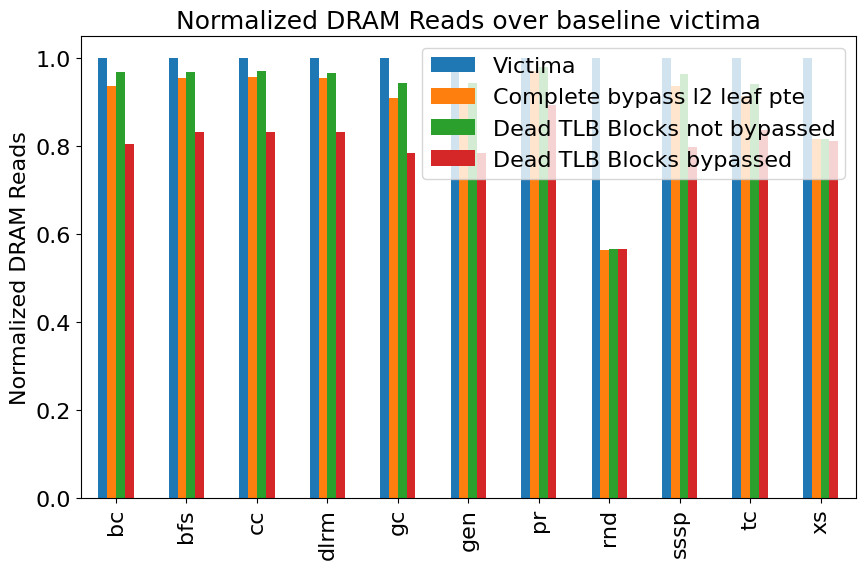

     Victima Complete bypass l2 leaf pte Dead TLB Blocks not bypassed  \
bc       1.0                    0.999361                     0.999609   
bfs      1.0                    0.999922                     0.999929   
cc       1.0                     0.99975                     0.999761   
dlrm     1.0                    0.999922                      0.99993   
gc       1.0                    0.999982                     0.999985   
gen      1.0                    0.999985                     0.999989   
pr       1.0                    0.999882                     0.999914   
rnd      1.0                    0.998131                      0.99814   
sssp     1.0                    0.997298                      0.99736   
tc       1.0                    0.999321                     0.999563   
xs       1.0                    0.991228                     0.991228   

     Dead TLB Blocks bypassed  
bc                   0.998189  
bfs                  0.999843  
cc                    0.999

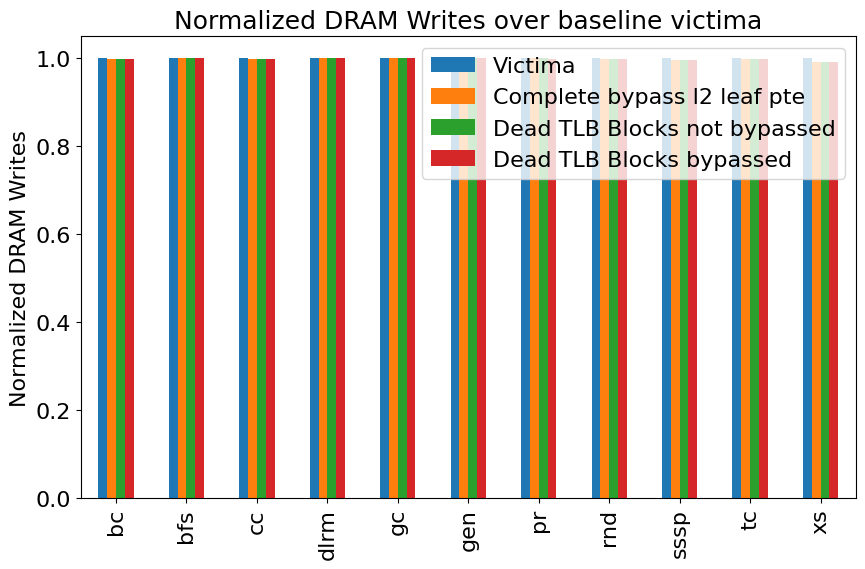

     Victima Complete bypass l2 leaf pte Dead TLB Blocks not bypassed  \
bc       1.0                    0.953897                     0.976471   
bfs      1.0                    0.958579                     0.970189   
cc       1.0                    0.959012                     0.971766   
dlrm     1.0                     0.95807                     0.969845   
gc       1.0                    0.911166                     0.946365   
gen      1.0                    0.911557                       0.9461   
pr       1.0                    0.976941                     0.983742   
rnd      1.0                    0.721929                     0.722109   
sssp     1.0                    0.937787                     0.965524   
tc       1.0                    0.920894                     0.946626   
xs       1.0                    0.817558                      0.81781   

     Dead TLB Blocks bypassed  
bc                   0.856205  
bfs                  0.843974  
cc                   0.8394

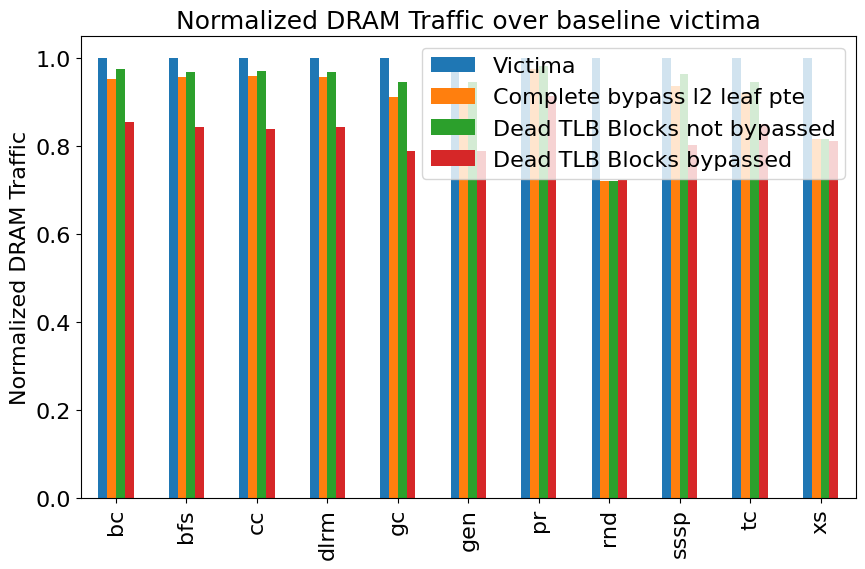

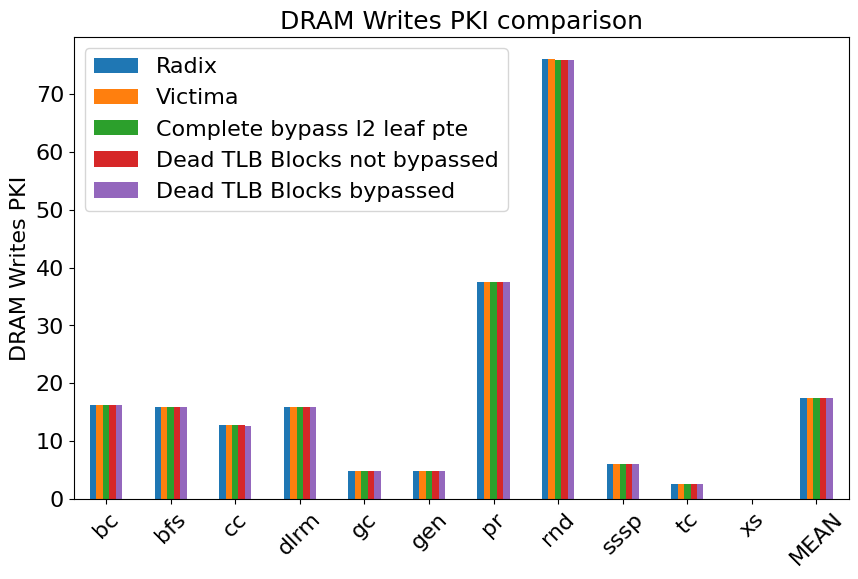

          Radix    Victima Complete bypass l2 leaf pte  \
bc    16.293052  16.312108                   16.301688   
bfs    15.87837  15.879224                   15.877984   
cc      12.7373  12.738866                   12.735686   
dlrm  15.878428  15.879228                   15.877996   
gc     4.905278   4.905382                    4.905294   
gen     4.90529   4.905376                    4.905304   
pr    37.474294  37.484222                   37.479796   
rnd   75.945564   75.96421                    75.82223   
sssp     6.0741    6.07965                     6.06322   
tc     2.706336   2.708566                    2.706728   
xs     0.000226   0.000228                    0.000226   
MEAN  17.527113   17.53246                   17.516014   

     Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
bc                      16.305728                16.282568  
bfs                     15.878102                15.876732  
cc                       12.73582                 12.73402  
d

In [31]:
def compare_dram(dram_data, label):
    cmps = []
    for i in range(1, len(dram_data)):
        cmps.append(normalize(dram_data[1], dram_data[i], label, headings[i]))

    cmp = compare(cmps, headings[1:], 'none')
    print(cmp)

    cmp.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Normalized ' + label)
    plt.title(f'Normalized {label} over baseline victima')
    # plt.ylim(1,3)

    plt.show()



compare_dram(drrs, 'DRAM Reads')
compare_dram(drws, 'DRAM Writes')
compare_dram(drts, 'DRAM Traffic')

# print(drwpki[0])

cmp = compare(drwpki, headings)
# Plot the comparison
cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('DRAM Writes PKI')
plt.title('DRAM Writes PKI comparison')


#add legend
# plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1.15), fontsize=14)

plt.xticks(rotation=45)
plt.show()
print(cmp)



### DRAM Latency Analysis

In [32]:
def get_dram_latency(df):
    label = 'DRAM Access Letency'
    dram_lat = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_lat.at[label, wl] = df[wl]['dram.total-access-latency']/(df[wl]['dram.reads'] + df[wl]['dram.writes'])
        dram_lat.at[label, wl] = convert_to_cycles(dram_lat.at[label, wl])

    return dram_lat.T

           Radix     Victima Complete bypass l2 leaf pte  \
bc    138.887722  139.993193                  140.292634   
bfs   139.405528  140.520319                  140.382672   
cc    139.906857  141.193738                  141.016107   
dlrm  139.402308   140.51795                  140.381282   
gc    139.070767   140.31684                  140.000516   
gen   139.061833  140.310122                  140.006144   
pr    132.572423  133.634127                  133.446284   
rnd   161.024498  164.220287                  165.685901   
sssp   136.79716  138.459664                  138.156849   
tc    138.239322  139.075834                  138.773564   
xs     139.05339  139.100018                  140.138872   
MEAN  140.311073  141.576554                  141.661893   

     Dead TLB Blocks not bypassed Dead TLB Blocks bypassed  
bc                     140.381816               139.497742  
bfs                    140.451061               139.462002  
cc                     141.107341   

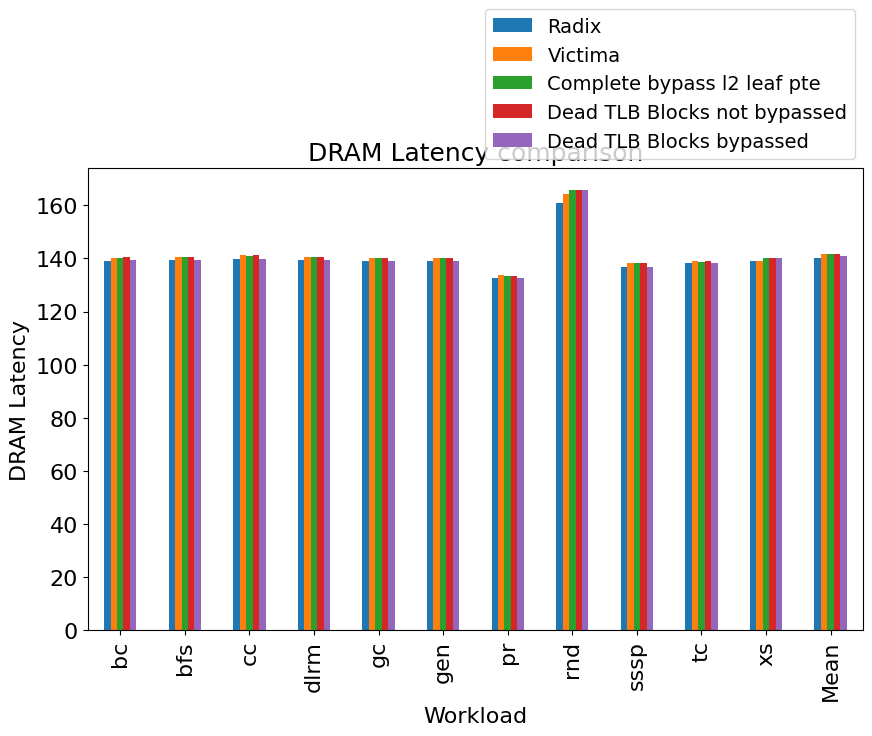

In [33]:
# Compare and plot the DRAM latency
drls = []
for df in data_dfs:
    drls.append(get_dram_latency(df))

# print(drls[0])

cmp = compare(drls, headings, 'mean')
print(cmp)

cmp.index = workloads + ['Mean']
cmp.index.name = 'Workload'

cmp.to_csv('res/Latencies/DRAM Latency.csv')

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('DRAM Latency')
plt.legend(loc='best', bbox_to_anchor=(0.5, 1), fontsize=14)
plt.title('DRAM Latency comparison')
plt.show()

## Get Miss Latency

In [34]:
# Now return a df as done in the previous function
# def get_cache_miss_penalty(df, cache_name):
#     label = f'{cache_name} Miss Penalty'
#     mpki = pd.DataFrame(index=[label], columns=workloads)
#     load_misses_attr = cache_name + '.t-misses-data'
#     store_misses_attr = cache_name + '.tstore-misses'
#     tot_latency_attr = cache_name + '.total-miss-latency-data'


#     for wl in workloads:
#         # mpki.at[label, wl] = round(df[wl][tot_latency_attr] / (df[wl][load_misses_attr] + df[wl][store_misses_attr]), 2)
#         mpki.at[label, wl] = round(df[wl][tot_latency_attr] / (df[wl][load_misses_attr]), 2)
#         mpki.at[label, wl] = convert_to_cycles(mpki.at[label, wl])

#     return mpki.T


# d = [get_cache_miss_penalty(di, 'L1-D') for di, li in zip(data_dfs, headings)]
# cmp = compare(d, headings)

# print(cmp)

# cmp.plot(kind='bar', figsize=(10, 6))
# plt.legend(loc='best', bbox_to_anchor=(0.5, 1), fontsize=14)
# plt.ylabel('L1-D Miss Penalty in Cycles')
# plt.title('L1-D Miss Penalty comparison')
# plt.show()


In [35]:
compare_attr(data_dfs, headings, 'L1-D.total-latency')

,Radix,Victima,Complete bypass l2 leaf pte,Dead TLB Blocks not bypassed,Dead TLB Blocks bypassed
bc,1221845477982087.0,1449348015522527.0,1361469273932705.0,1401876740682931.0,1170739876725103.0
bfs,6305826975071187.0,7141996266551686.0,6763188268638033.0,6845473783714896.0,5904079919293948.0
cc,7560023802507477.0,8588038407242180.0,8133417141716562.0,8243068949098160.0,7080835478793560.0
dlrm,6328676648676685.0,7148344140950044.0,6759129381211757.0,6844255985437342.0,5901768246761145.0
gc,5947093439797405.0,6959666538250150.0,6350670326275298.0,6575356672432489.0,5584438405617482.0
gen,5949453994832523.0,6959161712794129.0,6352228510198376.0,6572797075304627.0,5587968535051523.0
pr,4716584052289501.0,5134135206974857.0,4919305215106310.0,4961580057121170.0,4515676592176116.0
rnd,4859267906013236.0,5273646006930428.0,3179170030865251.0,3180302072409056.0,3189720207871415.0
sssp,6693900120965546.0,8076789474174827.0,7507399697645605.0,7721464302092705.0,6363278993353876.0
tc,795381892266712.0,906074968861789.0,815044950700755.0,840201271397916.0,747363050796279.0


## Occupancy

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc          60.132812   39.867188         0.0
bfs         65.608472   34.391528         0.0
cc          64.880542   35.119458         0.0
dlrm        65.152197   34.847803         0.0
gc          62.783057   37.216943         0.0
gen         62.729126   37.270874         0.0
pr          72.082324   27.917676         0.0
rnd         52.215967   47.784033         0.0
sssp        63.538940   36.461060         0.0
tc          73.054175   26.945825         0.0
xs          70.993677   29.006323         0.0
MEAN        64.833754   35.166246         0.0


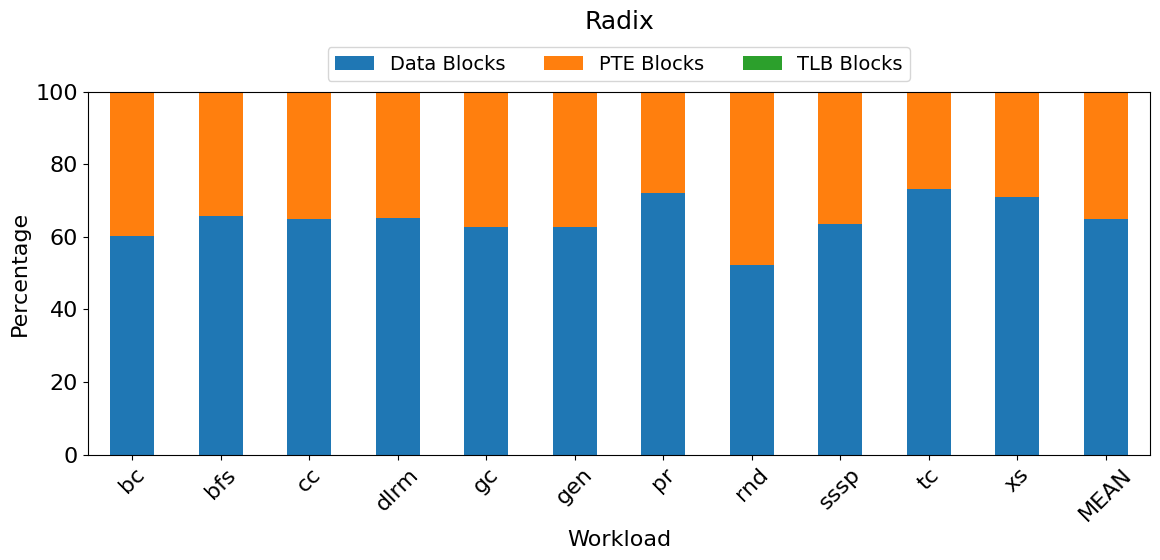

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc          49.724341   27.425928   22.849731
bfs         54.942383   18.356909   26.700708
cc          54.400415   18.689990   26.909595
dlrm        54.964282   18.336548   26.699170
gc          53.486304   23.360571   23.153125
gen         53.479150   23.357422   23.163428
pr          62.197729   15.536719   22.265552
rnd         39.346460   15.983032   44.670508
sssp        52.750000   24.794604   22.455396
tc          60.975952   16.840601   22.183447
xs          63.281958    7.402930   29.315112
MEAN        54.504452   19.098659   26.396888


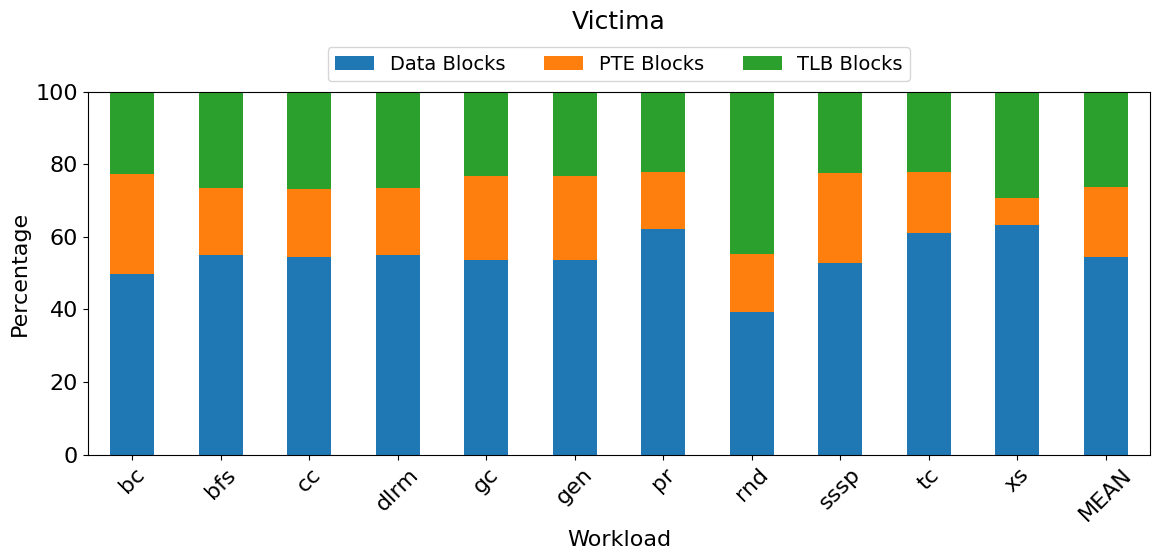

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc           0.000000   30.887242   69.112758
bfs          0.000000    8.768746   91.231254
cc           0.000000    8.743548   91.256452
dlrm         0.000000    8.692127   91.307873
gc           0.000850   25.766136   74.233015
gen          0.000829   25.555124   74.444048
pr           0.000000    4.165708   95.834292
rnd          0.012846    0.423919   99.563235
sssp         0.000000   27.388275   72.611725
tc           0.000000    3.988941   96.011059
xs           0.000000    5.943710   94.056290
MEAN         0.001320   13.665770   86.332909


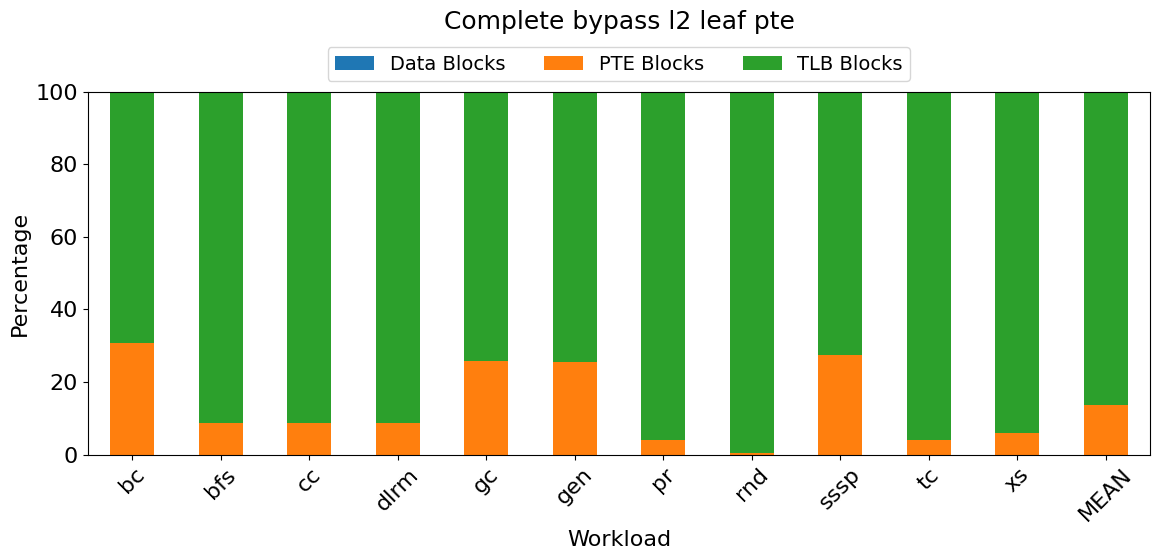

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc           0.000000   53.216730   46.783270
bfs          0.000000   42.113962   57.886038
cc           0.000000   42.266915   57.733085
dlrm         0.000000   42.073257   57.926743
gc           0.000796   49.465478   50.533727
gen          0.000772   49.483779   50.515448
pr           0.000000   41.440254   58.559746
rnd          0.000000    2.888109   97.111891
sssp         0.000000   51.860509   48.139491
tc           0.000000   38.550683   61.449317
xs           0.000000   24.577289   75.422711
MEAN         0.000143   39.812451   60.187406


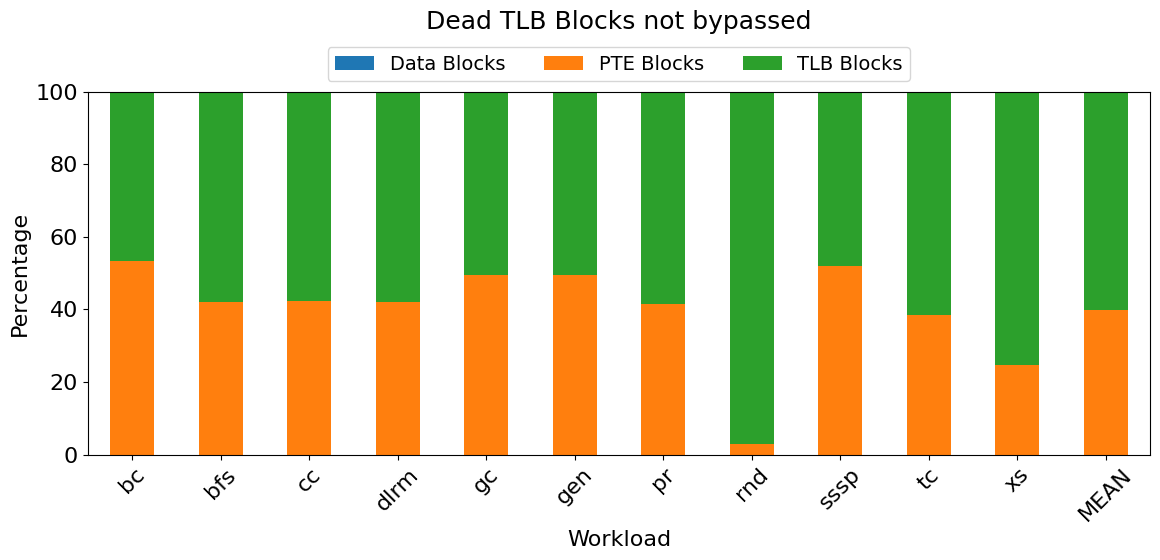

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc           0.000000   99.991943    0.008057
bfs          0.000000   79.751483   20.248517
cc           0.000000   79.526487   20.473513
dlrm         0.000000   79.547223   20.452777
gc           0.000808   84.637163   15.362030
gen          0.000694   84.417949   15.581357
pr           0.000000   81.695759   18.304241
rnd          0.000000    2.741875   97.258125
sssp         0.000000   92.449165    7.550835
tc           0.000000   77.270270   22.729730
xs           0.000000   45.240964   54.759036
MEAN         0.000137   73.388207   26.611656


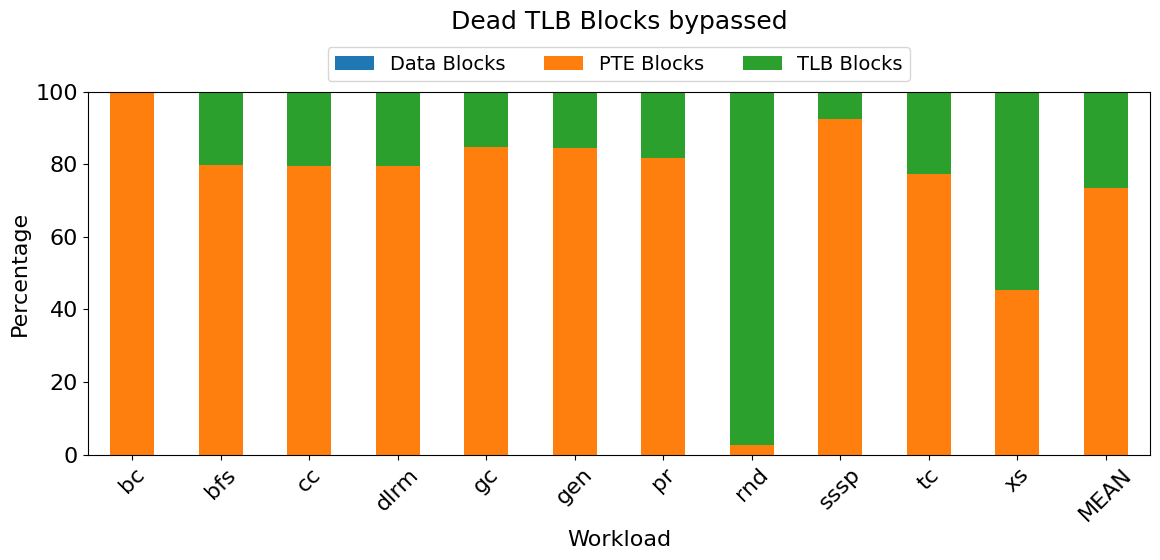

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_occupancy(folder_path, heading):
    # Initialize list to store final dataframe data
    final_data = []

    # Process each .out file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".out"):
            trace_name = file.replace(".out", "")
            file_path = os.path.join(folder_path, file)
            
            # Read the .out file and extract relevant data
            data = []
            with open(file_path, "r") as f:
                for line in f:
                    if "Occupancy in L2:" in line:
                        parts = line.strip().split(": ")[1].split(", ")
                        data.append([int(parts[0]), int(parts[1]), int(parts[2])])
            
            # Create a dataframe for the trace
            df = pd.DataFrame(data, columns=["num_data_blocks", "num_pte_blocks", "num_tlb_blocks"])


            # Compute average occupancy values for the bottom half
            bottom_half = df.iloc[len(df)//2:]

            # bottom_half = df

            total_blocks = bottom_half.sum(axis=1)
            avg_data_occupancy = ((bottom_half["num_data_blocks"] / total_blocks) * 100).mean()
            avg_pte_occupancy = ((bottom_half["num_pte_blocks"] / total_blocks) * 100).mean()
            avg_tlb_occupancy = ((bottom_half["num_tlb_blocks"] / total_blocks) * 100).mean()
            
            # Store the results for the final dataframe
            final_data.append([trace_name, avg_data_occupancy, avg_pte_occupancy, avg_tlb_occupancy])


    # Create final dataframe
    final_df = pd.DataFrame(final_data, columns=["workload", "Data Blocks", "PTE Blocks", "TLB Blocks"])

    # set index to workload
    final_df.set_index("workload", inplace=True)

    # bars except the MEAN row should be sorted by alphabetical order
    final_df = final_df.sort_index()

    # Add mean values for each block type
    final_df.loc['MEAN'] = final_df.mean()

    # Define custom colors
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

    # Plot a stacked bar chart with Y limit to 100
    ax = final_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)
    
    print(final_df)

    final_df.to_csv(f'occupancy-{heading}.csv')

    final_df.to_csv(f'res/Occupancy/{heading}.csv')


    if (heading == 'Victima'):
        final_df.to_csv('occupancy.csv')


    plt.ylabel("Percentage")
    plt.xlabel("Workload")


    # Move the plot title up


    plt.title(heading, pad=45)


    # plt.legend(title="Block Type", bbox_to_anchor=(1.05, 1), loc="lower right")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(final_df.columns), fontsize=14)

    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Run the function for each path
for i in range(0, len(paths)):
    plot_avg_occupancy(paths[i], headings[i])


## Translation Reach

          Radix     Victima  Complete bypass l2 leaf pte  \
workload                                                   
bc          0.0  116.990624                   334.781683   
bfs         0.0  136.707624                   438.847761   
cc          0.0  137.777124                   438.995893   
dlrm        0.0  136.699750                   439.183220   
gc          0.0  118.544000                   359.542225   
gen         0.0  118.596749                   360.499209   
pr          0.0  113.999624                   460.276889   
rnd         0.0  228.712999                   484.406250   
sssp        0.0  114.971624                   351.948213   
tc          0.0  113.579249                   461.150478   
xs          0.0  150.093374                   451.987854   
MEAN        0.0  135.152068                   416.510880   

          Dead TLB Blocks not bypassed  Dead TLB Blocks bypassed  
workload                                                          
bc                       

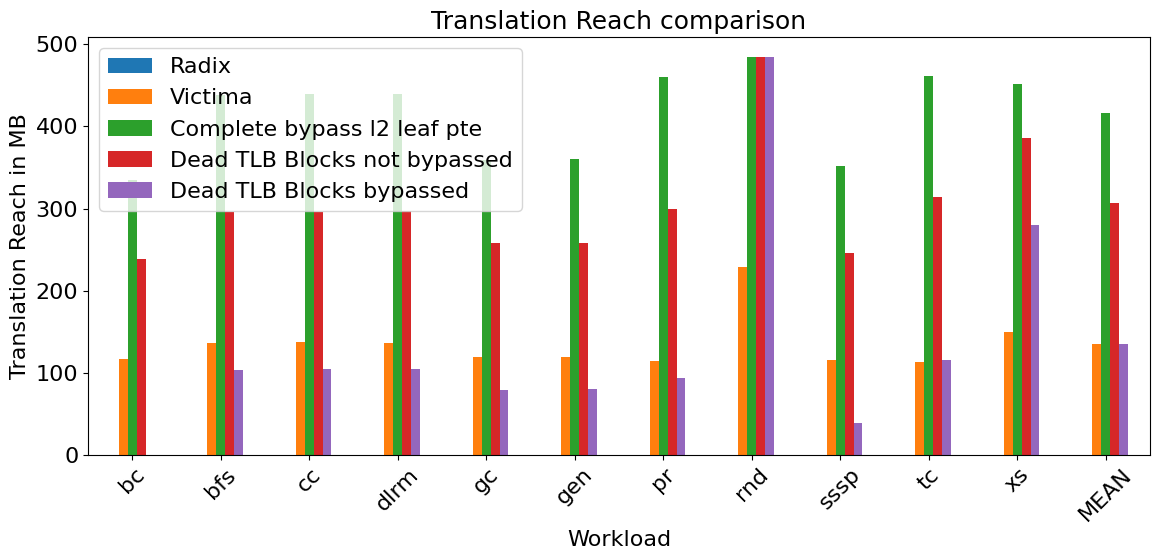

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_translation_reach(folder_path, heading):
    # Initialize list to store final dataframe data
    final_data = []

    # Process each .out file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".out"):
            trace_name = file.replace(".out", "")
            file_path = os.path.join(folder_path, file)
            
            # Read the .out file and extract relevant data
            data = []
            with open(file_path, "r") as f:
                for line in f:
                    if "Occupancy in L2:" in line:
                        parts = line.strip().split(": ")[1].split(", ")
                        data.append([int(parts[0]), int(parts[1]), int(parts[2])])
            
            # Create a dataframe for the trace
            df = pd.DataFrame(data, columns=["num_data_blocks", "num_pte_blocks", "num_tlb_blocks"])


            # Compute average occupancy values for the bottom half
            bottom_half = df.iloc[len(df)//2:]

            # bottom_half = df

            total_blocks = bottom_half.sum(axis=1)
            avg_tlb_occupancy = ((bottom_half["num_tlb_blocks"] / total_blocks) * 100).mean()
            
            tlb_blocks = avg_tlb_occupancy * total_blocks.mean() / 100


            # Store the results for the final dataframe
            final_data.append([trace_name, tlb_blocks])

    # Create final dataframe
    final_df = pd.DataFrame(final_data, columns=["workload", "TLB Blocks"])
    # set index to workload
    final_df.set_index("workload", inplace=True)
    # bars except the MEAN row should be sorted by alphabetical order
    final_df = final_df.sort_index()
    # Add mean values for each block type
    final_df.loc['MEAN'] = final_df.mean()


    # Add a column for translation reach, which will be num_tlb_blocks * 4096
    final_df['Translation Reach'] = final_df['TLB Blocks'] * 4096 * 8
    final_df['Translation Reach'] = final_df['Translation Reach'].astype(int)


    # Convert the translation reach to MB
    final_df['Translation Reach'] = final_df['Translation Reach']/ 1024 / 1024

    # drop the TLB blocks column
    final_df = final_df.drop(columns=['TLB Blocks'])

    return final_df



results = []

# Run the function for each path
for i in range(0, len(paths)):
    results.append(get_translation_reach(paths[i], headings[i]))

# print(results[0])

# concatenate the results
cmp = pd.concat(results, axis=1)
cmp.columns = headings
print(cmp)

# Plot the comparison
cmp.plot(kind='bar', figsize=(12, 6))
plt.ylabel("Translation Reach in MB")
plt.xlabel("Workload")
plt.title('Translation Reach comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
cmp.to_csv('translation_reach.csv')


cmp.to_csv('res/Translation_Reach/Translation Reach.csv')






## Dead block predictor accuracy

In [39]:
def get_dead_block_accuracy(df):
    label1 = 'Dead Accuracy'
    pred_stats = pd.DataFrame(index=[label1], columns=workloads)

    for wl in workloads:
        pred_stats.at[label1, wl] = df[wl]['dead_tlb_block_predictor.deadblocks_predicted_correctly']/df[wl]['dead_tlb_block_predictor.deadblocks_predicted']

    return pred_stats.T


def get_live_block_accuracy(df):
    label1 = 'Live Block Accuracy'
    pred_stats = pd.DataFrame(index=[label1], columns=workloads)

    for wl in workloads:
        pred_stats.at[label1, wl] = df[wl]['dead_tlb_block_predictor.liveblocks_predicted_correctly']/df[wl]['dead_tlb_block_predictor.liveblocks_predicted']

    return pred_stats.T


compare([get_dead_block_accuracy(data_dfs[3]), get_live_block_accuracy(data_dfs[3])], ['Dead Block Accuracy', 'Live Block Accuracy'], mean_type='mean')


# compare_attr([data_dfs[3]], ['Number of entries'], 'dead_tlb_block_predictor.num_entries')




,Dead Block Accuracy,Live Block Accuracy
bc,0.942477,0.767647
bfs,0.853418,0.459831
cc,0.852064,0.46042
dlrm,0.853386,0.459491
gc,0.880437,0.78103
gen,0.880436,0.780203
pr,0.858922,0.902507
rnd,0.304744,0.038883
sssp,0.892672,0.756513
tc,0.82787,0.77373
